In [1]:
import sys 
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/Code/")
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/Code/gaussian_process_gpmp")
from dataset_generation import sampler, extract_K_samples
from dataset_visualization import check_if_plot_is_possible, plot_1D_function, plot_2D_function_3D, plot_2D_function_heatmap
from gaussian_process import mu0_initial_guess, GaussianProcess
from gaussian_process_evaluation import GaussianProcessEvaluation
from results_visualization import ResultsVisualization

Using backend: torch
Using backend: torch


# Parameters

In [2]:
# Dataset
function_name           = "Slide function"
space_size              = 10
N_function              = 500
all_function_parameters = {"Power sinus 1D"                : {"Power" : 2},
                           "Heaviside 1D"                  : {"x gaps" : [0, 0.5, 1], "steps value" : [1, -1], "sigma noises" : [0.2, 0.2]},
                           "Multimodal sinus 1D"           : {"x gaps" : [0, 0.5, 1], "speeds value" : [1, 2]},
                           "Noisy sinus 1D"                : {"sigma noise" : 0.2},
                           "Sinus times x 1D"              : {},
                           "Sinus cardinal 1D"             : {},
                           "Slide function"                : {},
                           "Two bumps"                     : {},
                           "Power sinus 2D"                : {"Power" : 1},
                           "Heaviside 2D"                  : {"x gaps" : [0, 1, 2], "steps value" : [1, -1], "sigma noises" : [0.2, 0.2]},
                           "Multimodal sinus 2D"           : {"x gaps" : [0, 1, 2], "speeds value" : [1, 2]},
                           "Noisy sinus 2D"                : {"sigma noise" : 0.2},
                           "Sinus times x 2D"              : {},
                           "Sinus cardinal 2D"             : {},
                           "Gaussian process trajectory"   : {"sigma0" : 1, "theta" : 1},
                           "Concrete compressive strength" : {},
                           "Energy efficiency"             : {},
                           "Auto mpg"                      : {},
                           "Combined cycle power plant"    : {},
                           "Airfoil self-noise"            : {},
                           "Morokoff & caflisch 1"         : {"Dimension" : 2},
                           "Morokoff & caflisch 2"         : {"Dimension" : 2},
                           "Branin"                        : {},
                           "Branin hoo"                    : {},
                           "Goldstein"                     : {},
                           "Goldstein price"               : {},
                           "Rosenbrock4"                   : {},
                           "Hartman4"                      : {},
                           "Hartman6"                      : {},
                           "Sphere6"                       : {},
                           "Iooss1"                        : {},
                           "Iooss2"                        : {},
                           "Wing weight"                   : {},
                           "Sobol"                         : {"a" : [1, 10]},
                           "Two input toy"                 : {},
                           "Highly non linear"             : {},
                           "Mystery"                       : {},
                           "Six hump camelback"            : {},
                           "Ishigami"                      : {}
                          }
N_train                 = 10
N_test                  = 30
generate_new_points     = True

# Dataset visualization
library                 = "matplotlib"
plot_type_2D            = "heatmap" # 3D or heatmap
save_path               = "C:/Users/L2S/Desktop/Efficient_and_reliable_GP/Results/"

# Gaussian process
p                       = 5
nugget                  = 1e-12
initialization_method   = "GPMP" # GPMP, Moment-based, Custom
optimization_method     = "MLE" # REML, MLE, REML - PVA, MLE - PVA, PMLE, PMLE - PVA, MSE - PVA 
custom_covparam0        = {"sigma2" : 1, "rho" : [1, 1]}
bounds                  = {"sigma2" : [0.01, 0.02], "rho" : [[0.1, 0.2] for _ in range(2)]} if 0 else None

# Gaussian process evaluation
n_alpha                       = 1000
range_log_sigma2              = (-5, 5)
range_log_inv_rho             = (-7, 7)
n_optimization_functions_plot = 100

# Results visualization
alpha                   = 0.95

# 1 - Dataset generation

We have a determinist dynamic $y = f(\boldsymbol{x})$ that we wish to approximate using Gaussian processes.

We generate a random dataset $\mathcal{D} = \{ (\boldsymbol{x}_1,f(\boldsymbol{x}_1)),...,(\boldsymbol{x}_{N_{function}},f(\boldsymbol{x}_{N_{function}})) \}$ of $N_{function}$ points. We then randomly draw $\mathcal{D}_{train} = \{ (\boldsymbol{x}_1,f(\boldsymbol{x}_1)),...,(\boldsymbol{x}_{N_{train}},f(\boldsymbol{x}_{N_{train}})) \}$ and $\mathcal{D}_{test} = \{ (\boldsymbol{x}_1,f(\boldsymbol{x}_1)),...,(\boldsymbol{x}_{N_{test}},f(\boldsymbol{x}_{N_{test}})) \}$ mutually distinct points among those generated.

We choose a kernel family $k_{\boldsymbol{\theta}}(\boldsymbol{x}_*, \boldsymbol{x}_*')$. To make predictions on $\mathcal{D}_{test}$, we are going to:
- Tune the hyperparameters ${\boldsymbol{\theta}}$ using the observed data $\mathcal{D}_{train}$.
- Compute the posterior Gaussian process.
- Compute the predictions.
  

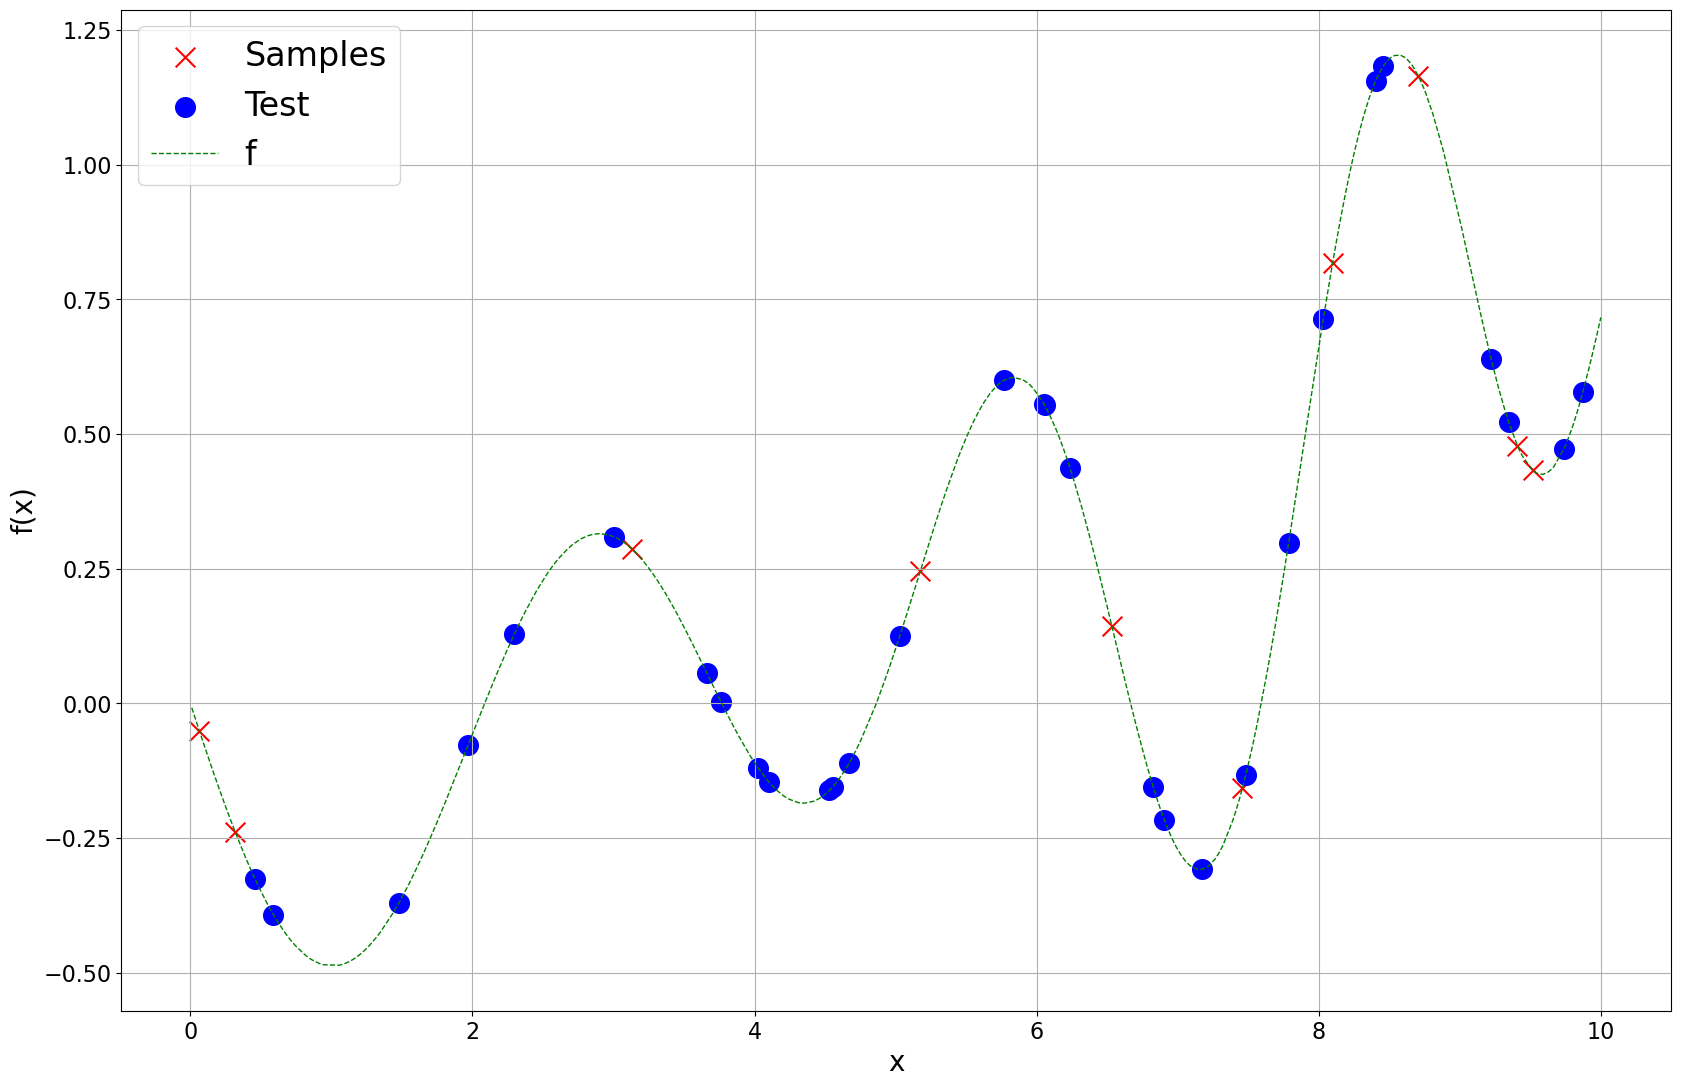

In [3]:
if generate_new_points:
    X_function, Y_function = sampler          (space_size, N_function, function_name, all_function_parameters)
    X, Y                   = extract_K_samples(X_function, Y_function, N_train + N_test)
    X_observed, Y_observed = X[:N_train], Y[:N_train ]
    X_test    , Y_test     = X[N_train:], Y[ N_train:]
if check_if_plot_is_possible(function_name) == "1D plot":
    plot_1D_function(X_observed, Y_observed, X_test, Y_test, X_function, Y_function, library, save_path, function_name)
if check_if_plot_is_possible(function_name) == "2D plot":
    if plot_type_2D == "3D":
        plot_2D_function_3D     (X_observed, Y_observed, X_test, Y_test, X_function, function_name, all_function_parameters[function_name], library, save_path)
    if plot_type_2D == "heatmap":
        plot_2D_function_heatmap(X_observed, Y_observed, X_test, Y_test, X_function, function_name, all_function_parameters[function_name], library, save_path)

# 2 - Hyperparameters initial guess

We compute the empirical mean $\frac{1}{N_{train}} \sum_{n=1}^{N_{train}} f(\boldsymbol{x}_n) $ of the observed function values to choose $\mu_0$. We then substract to $f$ the mean $\mu_0$ to simplify the computations. We thus now assume that we have a zero-mean Gaussian process.

In [4]:
mu0 = mu0_initial_guess(Y_observed)

# 3 - Gaussian process regression

We use $\mathcal{D}_{train}$ to tune hyperparameters and compute the posterior Gaussian process. We have:
- $GP^{posterior} = GP^{prior} | \mathcal{D}_{train} = \mathcal{GP}(m^{posterior}(\boldsymbol{x}_*), k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_*, \boldsymbol{x}_*'))$.
- $m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_*) = k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{x}_*)^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})$.
- $k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_*, \boldsymbol{x}_*')) = k_{\boldsymbol{\theta}}(\boldsymbol{x}_*, \boldsymbol{x}_*') - k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{x}_*')^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{x}_*)$.

In [5]:
gaussian_process = GaussianProcess(X_observed, Y_observed, mu0, p, initialization_method, optimization_method, custom_covparam0, bounds, nugget)
gaussian_process.create_and_train_gaussian_process()
#gaussian_process.set_gaussian_process_hyperparameters(0.12, [1.42])

None


# 4 - Gaussian process evaluation

We compute the performances of our trained Gaussian process using both the train set $\{ \boldsymbol{X}_{train}, f(\boldsymbol{X}_{train}) \}$ and the test set $\{ \boldsymbol{X}_{test}, f(\boldsymbol{X}_{test}) \}$. We have the following predictions:
- $\mu_{\boldsymbol{\theta}} = k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{test})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})$.
- $\Sigma_{\boldsymbol{\theta}} = k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) - k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{test})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{test})$.

In [6]:
gaussian_process_evaluation = GaussianProcessEvaluation(gaussian_process, X_observed, Y_observed, X_test, Y_test, X_function, Y_function, n_alpha, range_log_sigma2, range_log_inv_rho, n_optimization_functions_plot)
evaluation                  = gaussian_process_evaluation.evaluation()
hyperparameters             = evaluation["Hyperparameters"]
hyperparameters             = evaluation["Hyperparameters"]
print("Time           : ", hyperparameters["Time"          ])
print("mu0            : ", hyperparameters["mu0"           ])
print("sigma0         : ", hyperparameters["sigma0"        ])
print("Noise          : ", hyperparameters["Noise"         ])
for i in range(len(hyperparameters) - 4):
    print("Length scale {} : ".format(i), hyperparameters["Length scale {}".format(i)])
results_visualization = ResultsVisualization(function_name, all_function_parameters[function_name], gaussian_process, evaluation, optimization_method, alpha, library, save_path)
results_visualization.create_new_folder_for_usecase()

Time           :  0.12012839317321777
mu0            :  0.3124052519825356
sigma0         :  0.41324065616612743
Noise          :  1e-12
Length scale 0 :  0.8412945526250036


# 5 - Predictions

### 5.1 - Function predictions

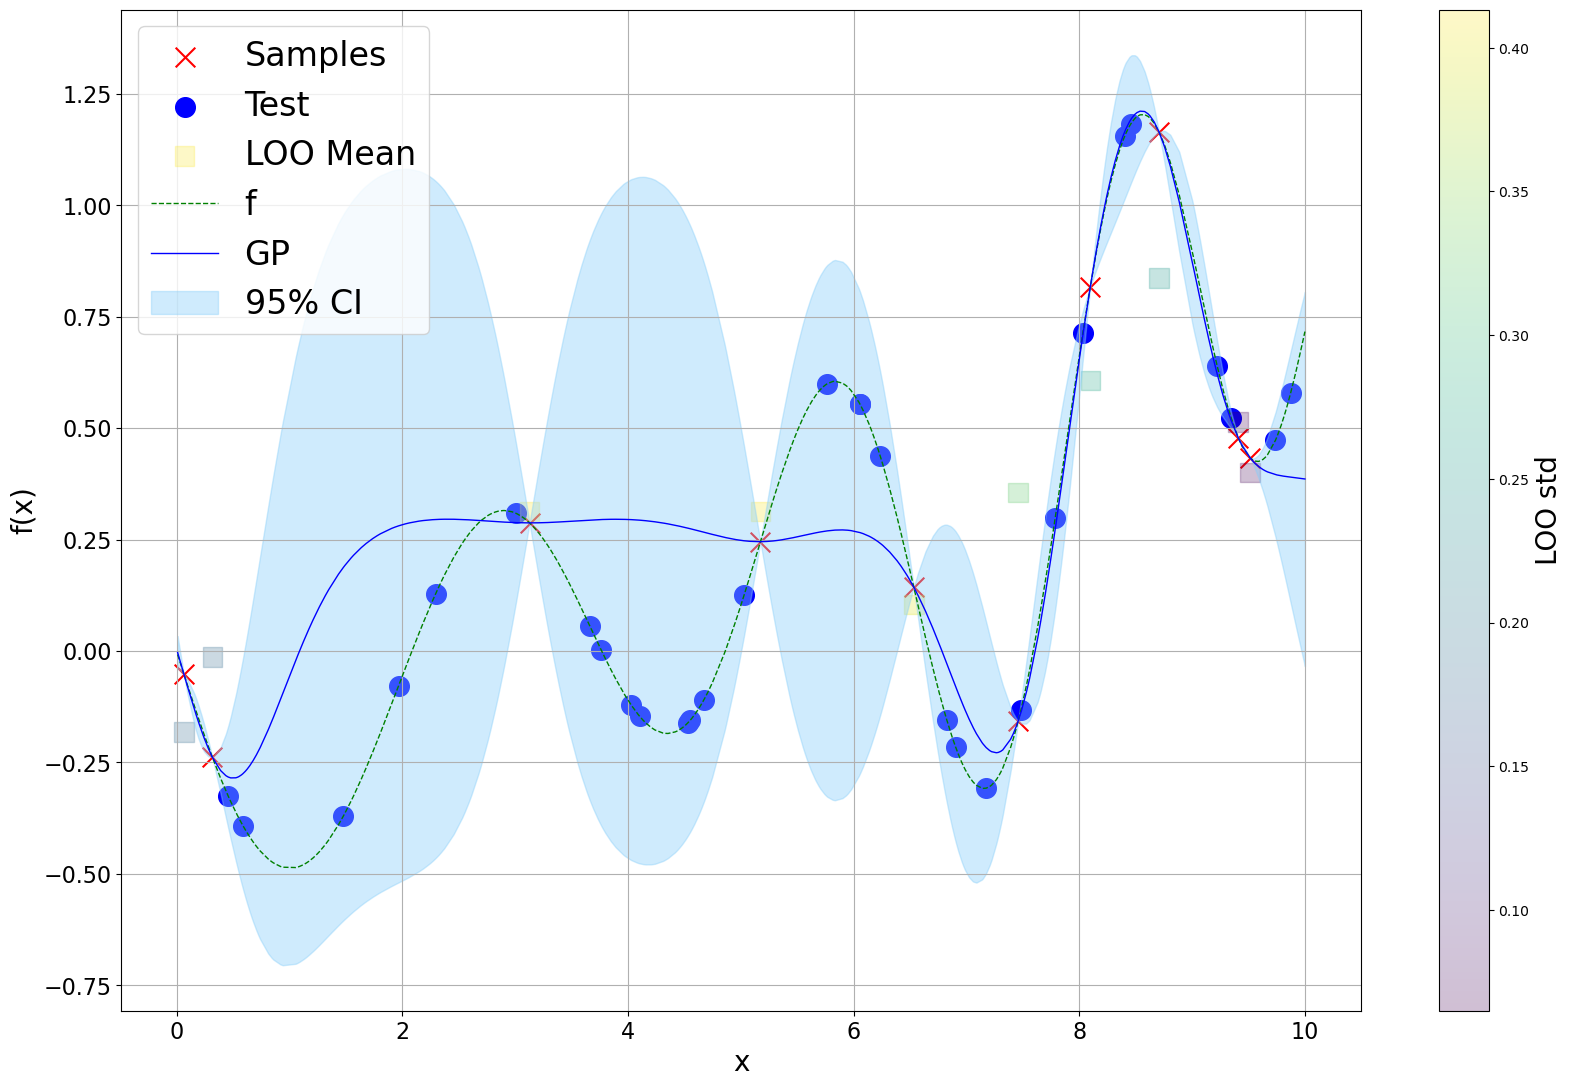

In [7]:
if check_if_plot_is_possible(function_name) == "1D plot":
    results_visualization.plot_1D_function_prediction()
if check_if_plot_is_possible(function_name) == "2D plot":
    if plot_type_2D == "3D":
        results_visualization.plot_2D_function_prediction_3D()
    if plot_type_2D == "heatmap":
        results_visualization.plot_2D_function_prediction_heatmap()

### 5.2 - Actual vs predicted

##### 5.2.1 - Train

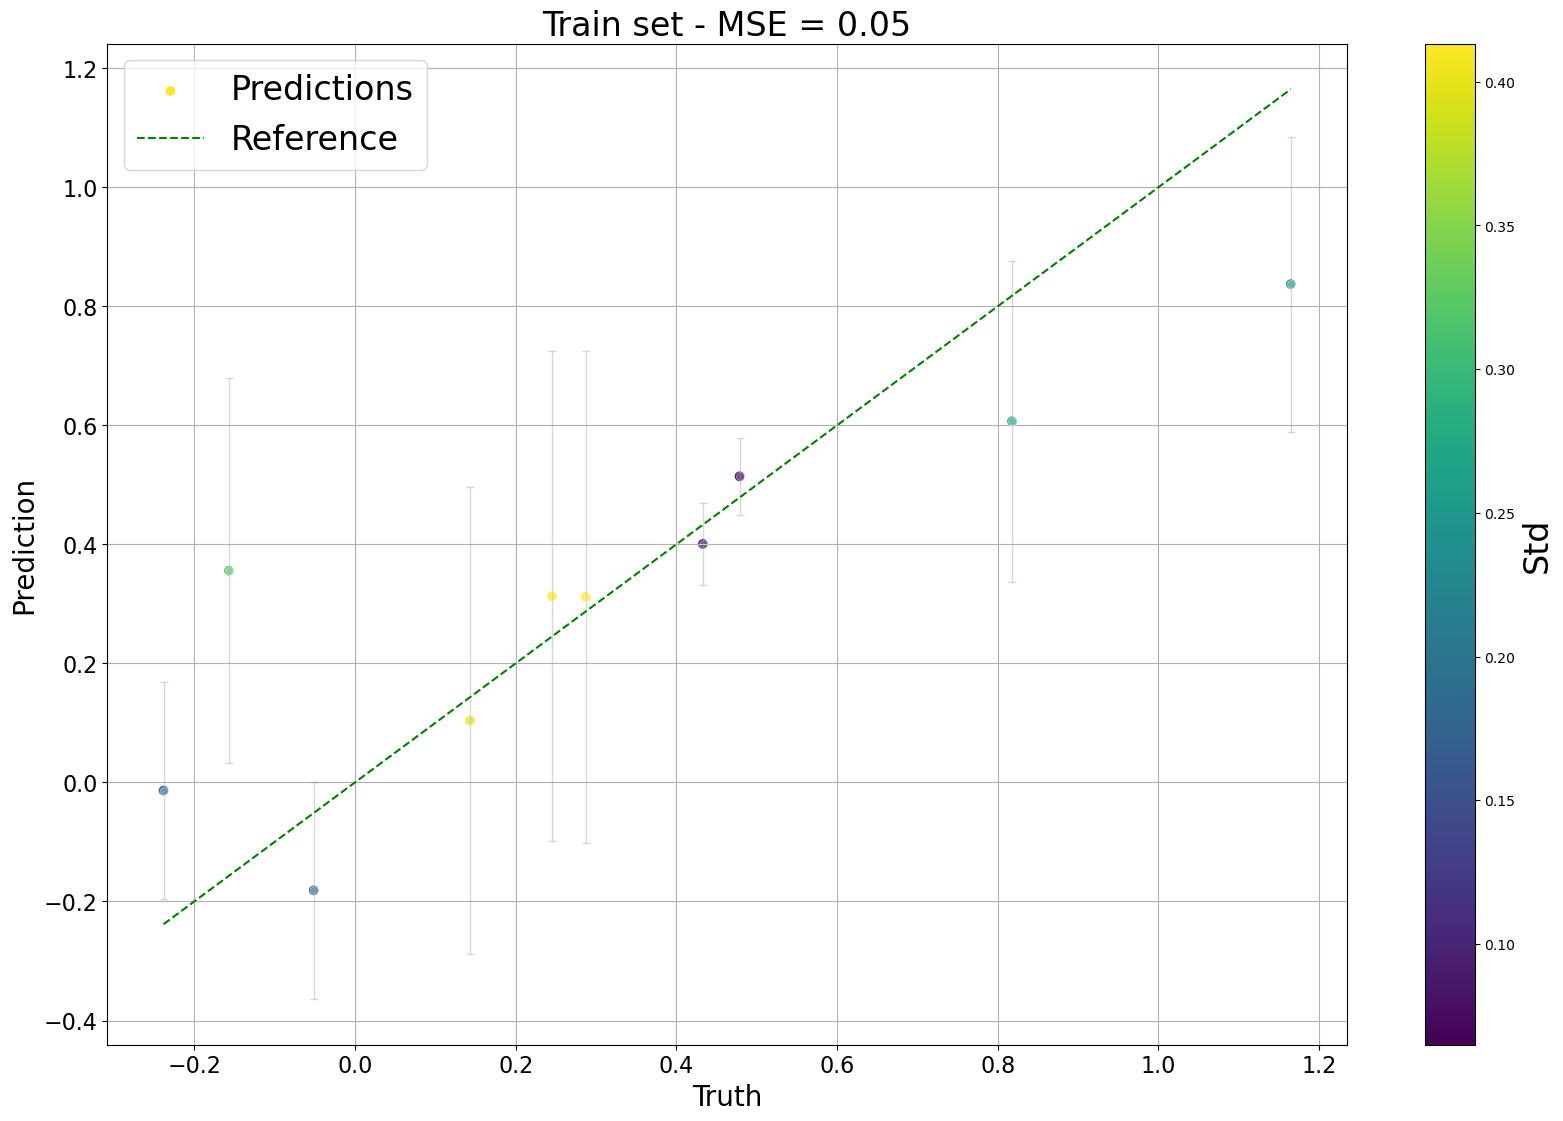

In [8]:
results_visualization.plot_predictions("Train")

##### 5.2.2 - Test

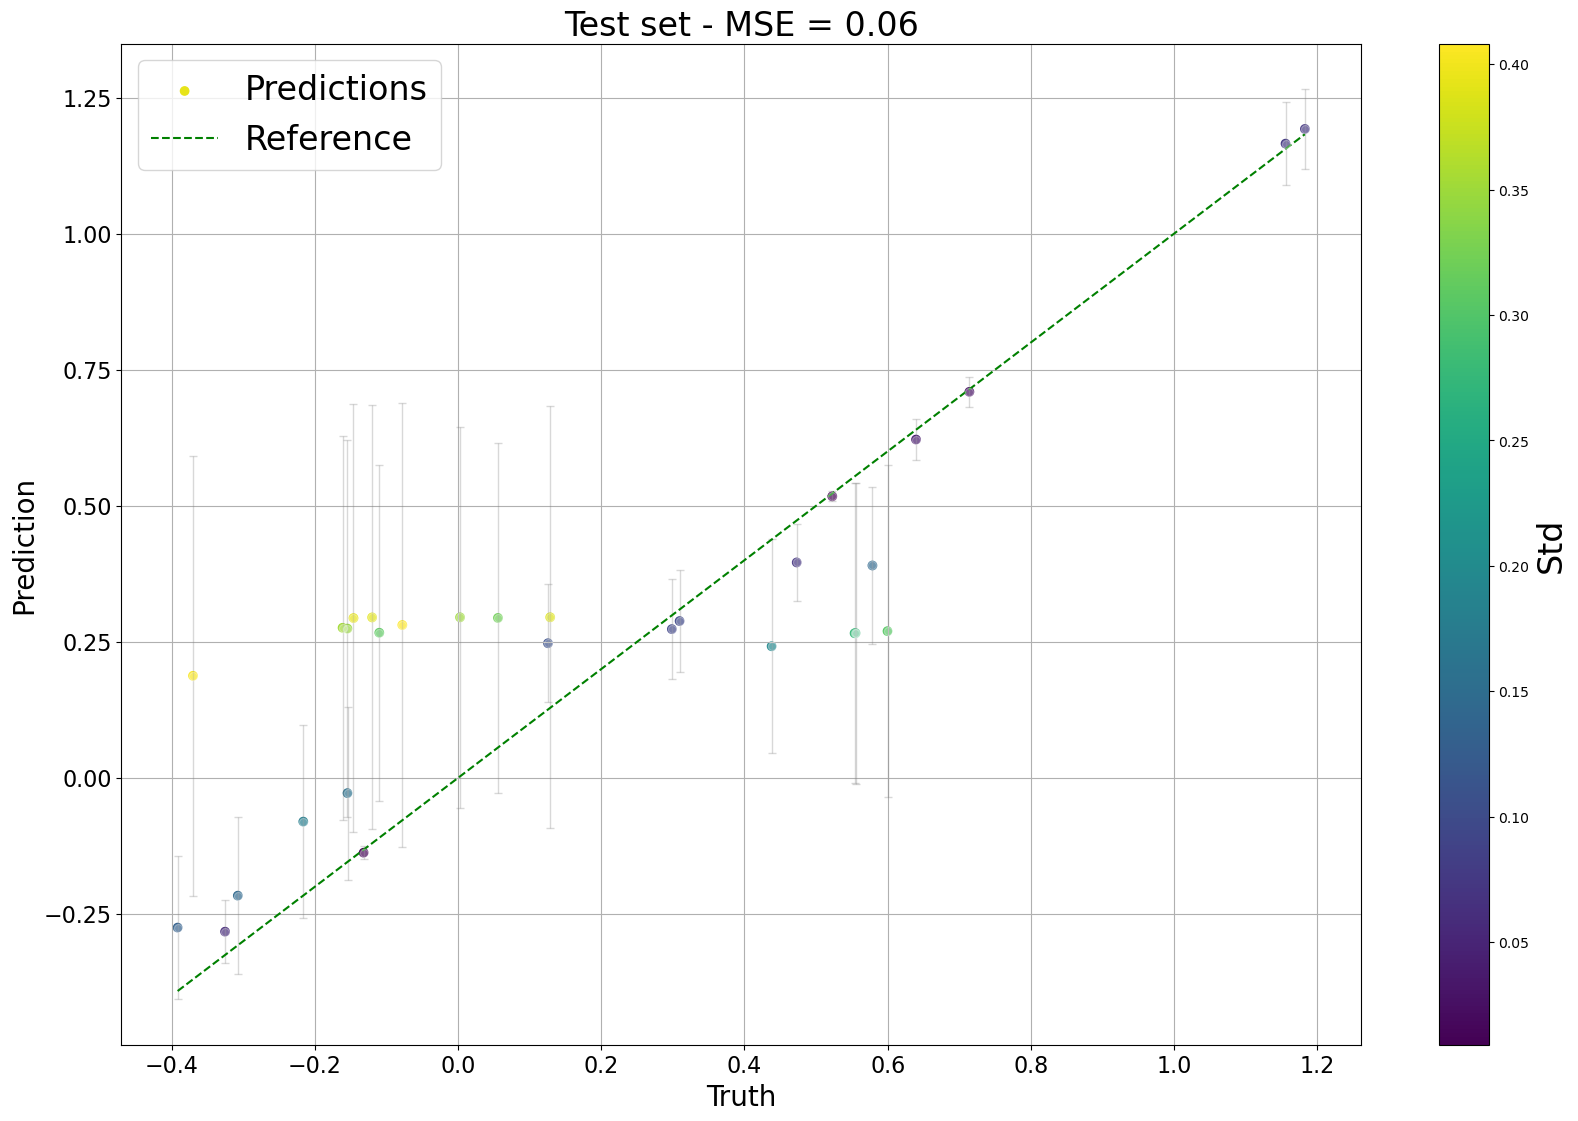

In [9]:
results_visualization.plot_predictions("Test")

# 6 - Hyperparameters optimization

### 6.1 - Optimization problem history

##### 6.1.1 - Hyperparameters history

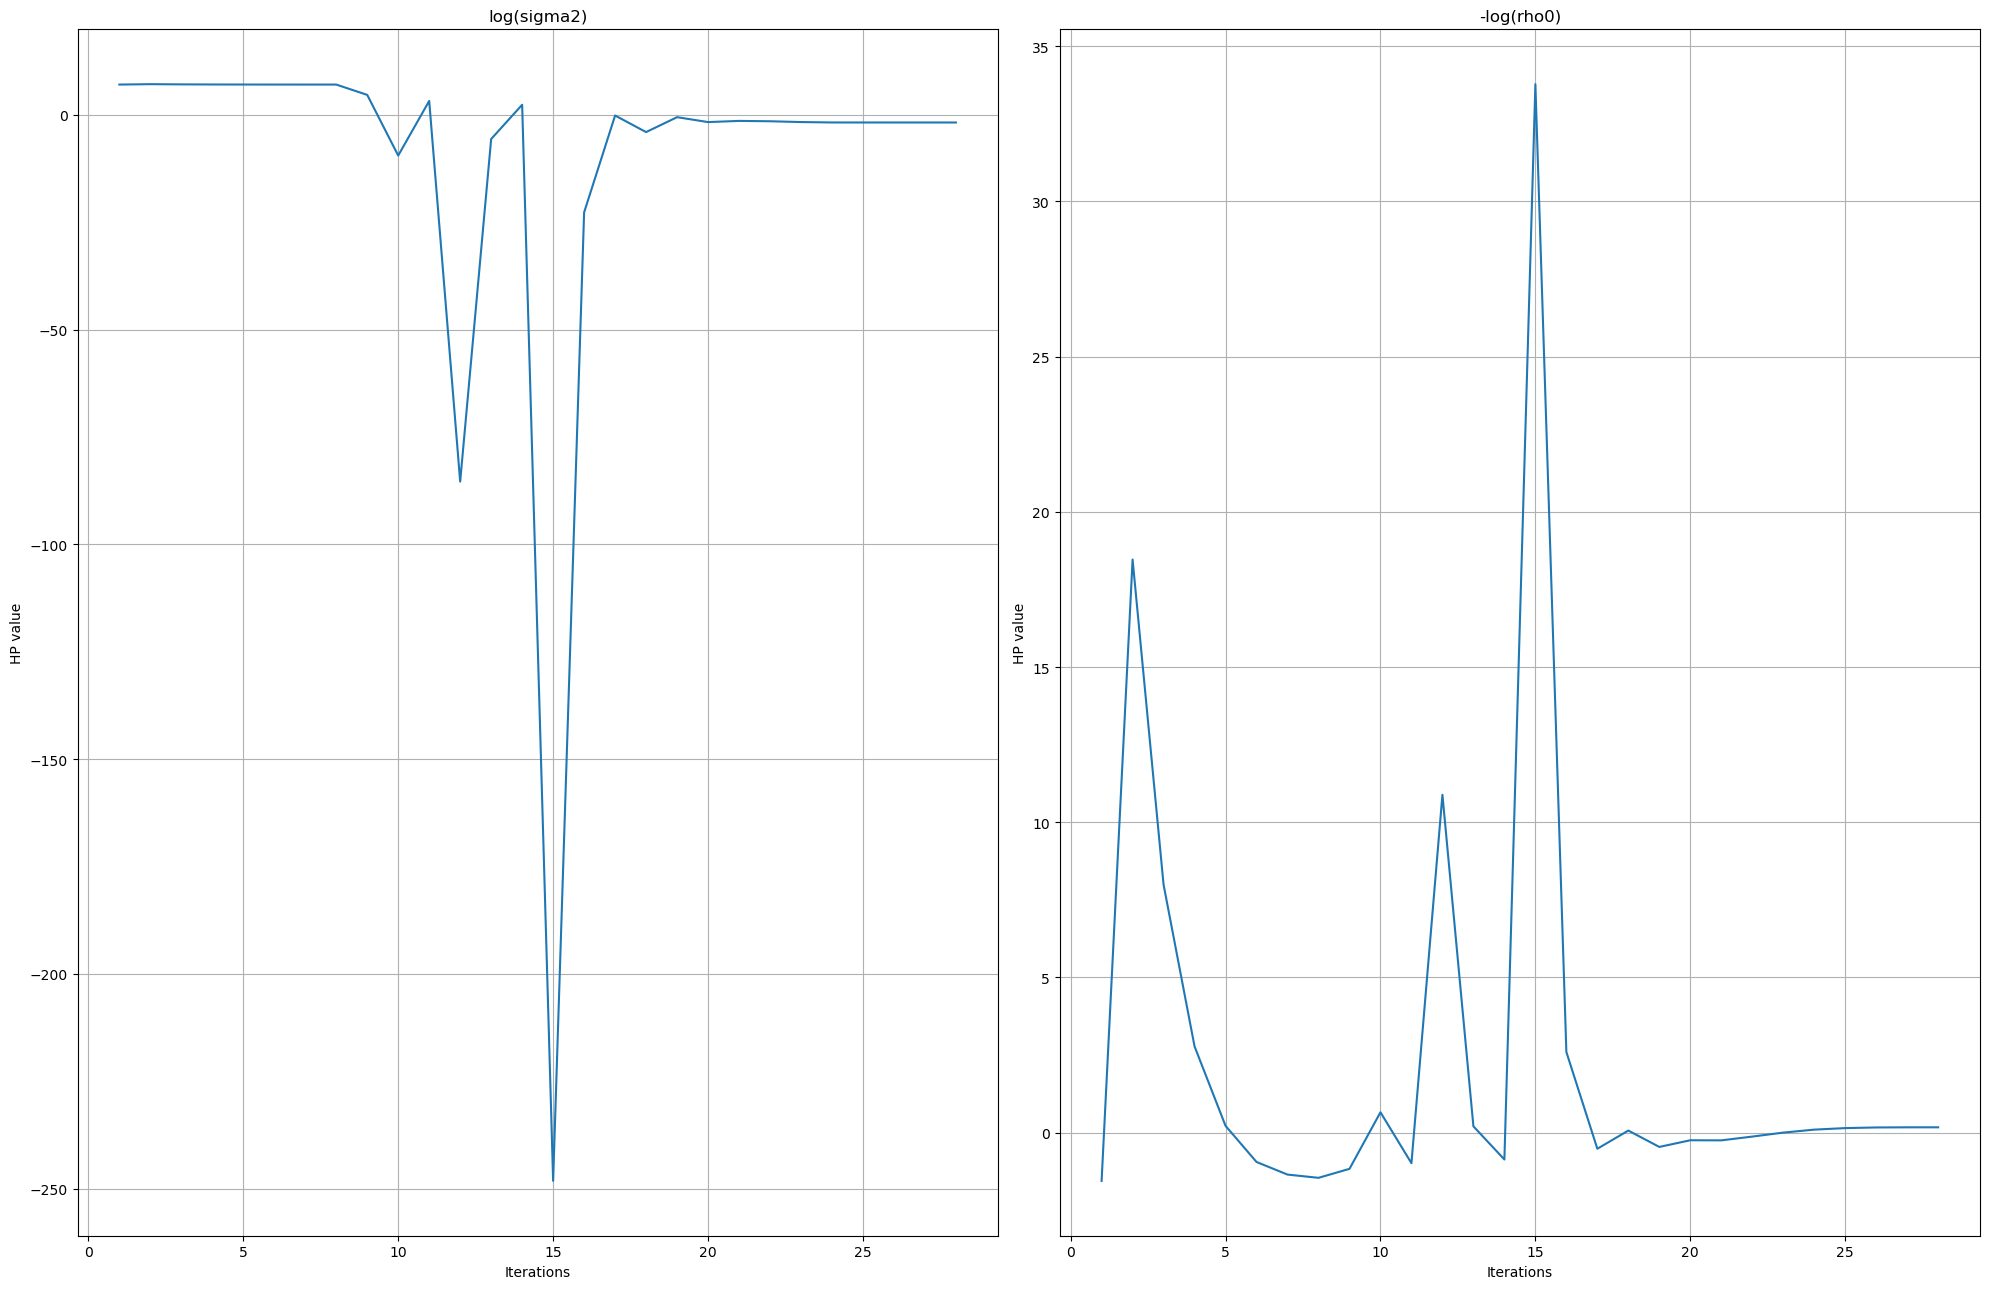

In [10]:
results_visualization.plot_hyperparameters_history()

##### 6.1.2 - Criterion history

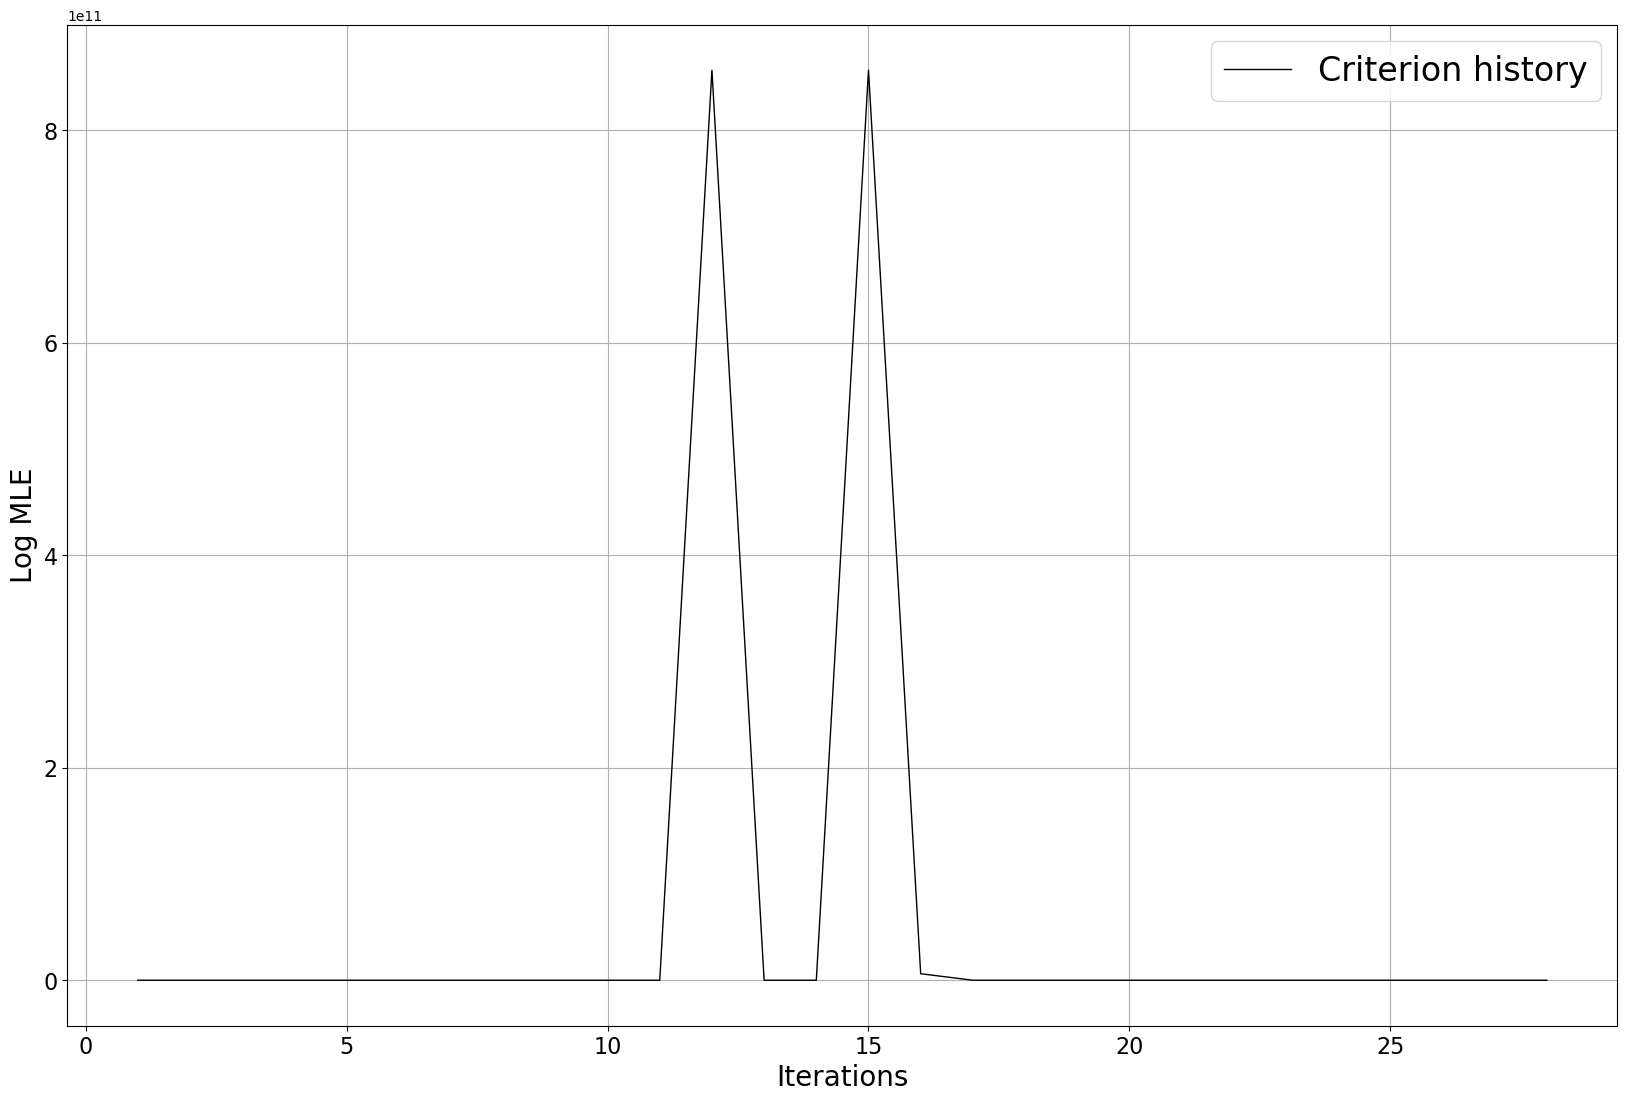

In [11]:
results_visualization.plot_criterion_history()

### 6.2 - Optimization function

##### 6.2.1 - Negative log likelihood

We have $l(\boldsymbol{\theta}) = f(\boldsymbol{X}_{train})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train}) + \log (\left|k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})\right|)$.

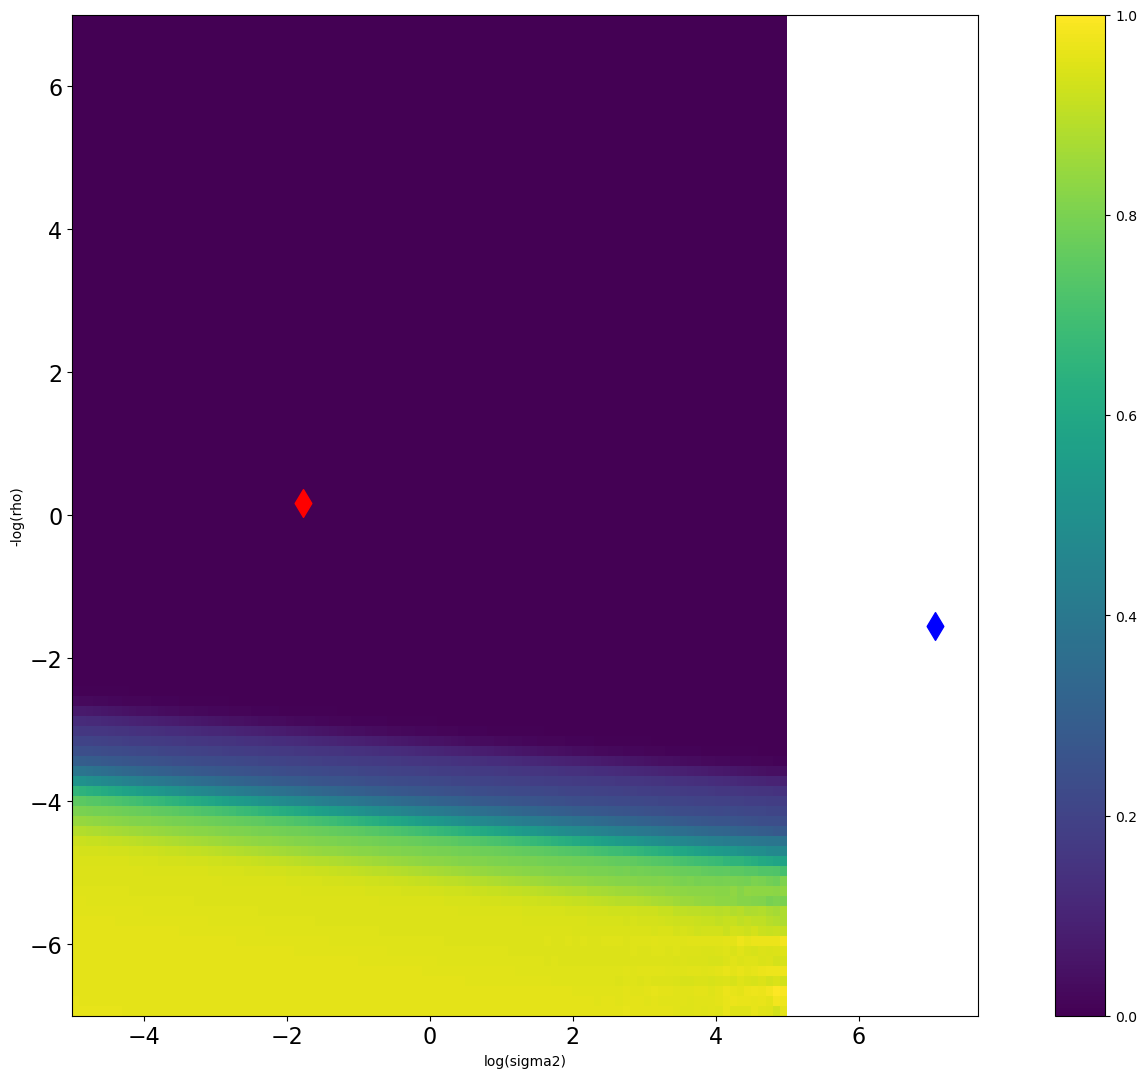

In [12]:
log_scale = False
if len(X_observed[0]) == 1:
    if plot_type_2D == "3D":
        results_visualization.plot_negative_log_likelihood_evolution_2D_3D(log_scale)
    if plot_type_2D == "heatmap":
        results_visualization.plot_negative_log_likelihood_evolution_2D_heatmap(log_scale)
if len(X_observed[0]) > 1:
    results_visualization.plot_negative_log_likelihood_evolution_nD(log_scale)

##### 6.2.2 - Profiled negative log likelihood

We have $l(\boldsymbol{\theta}) = log(f(\boldsymbol{X}_{train})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})) + \frac{1}{n} \log (\left|k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})\right|)$.

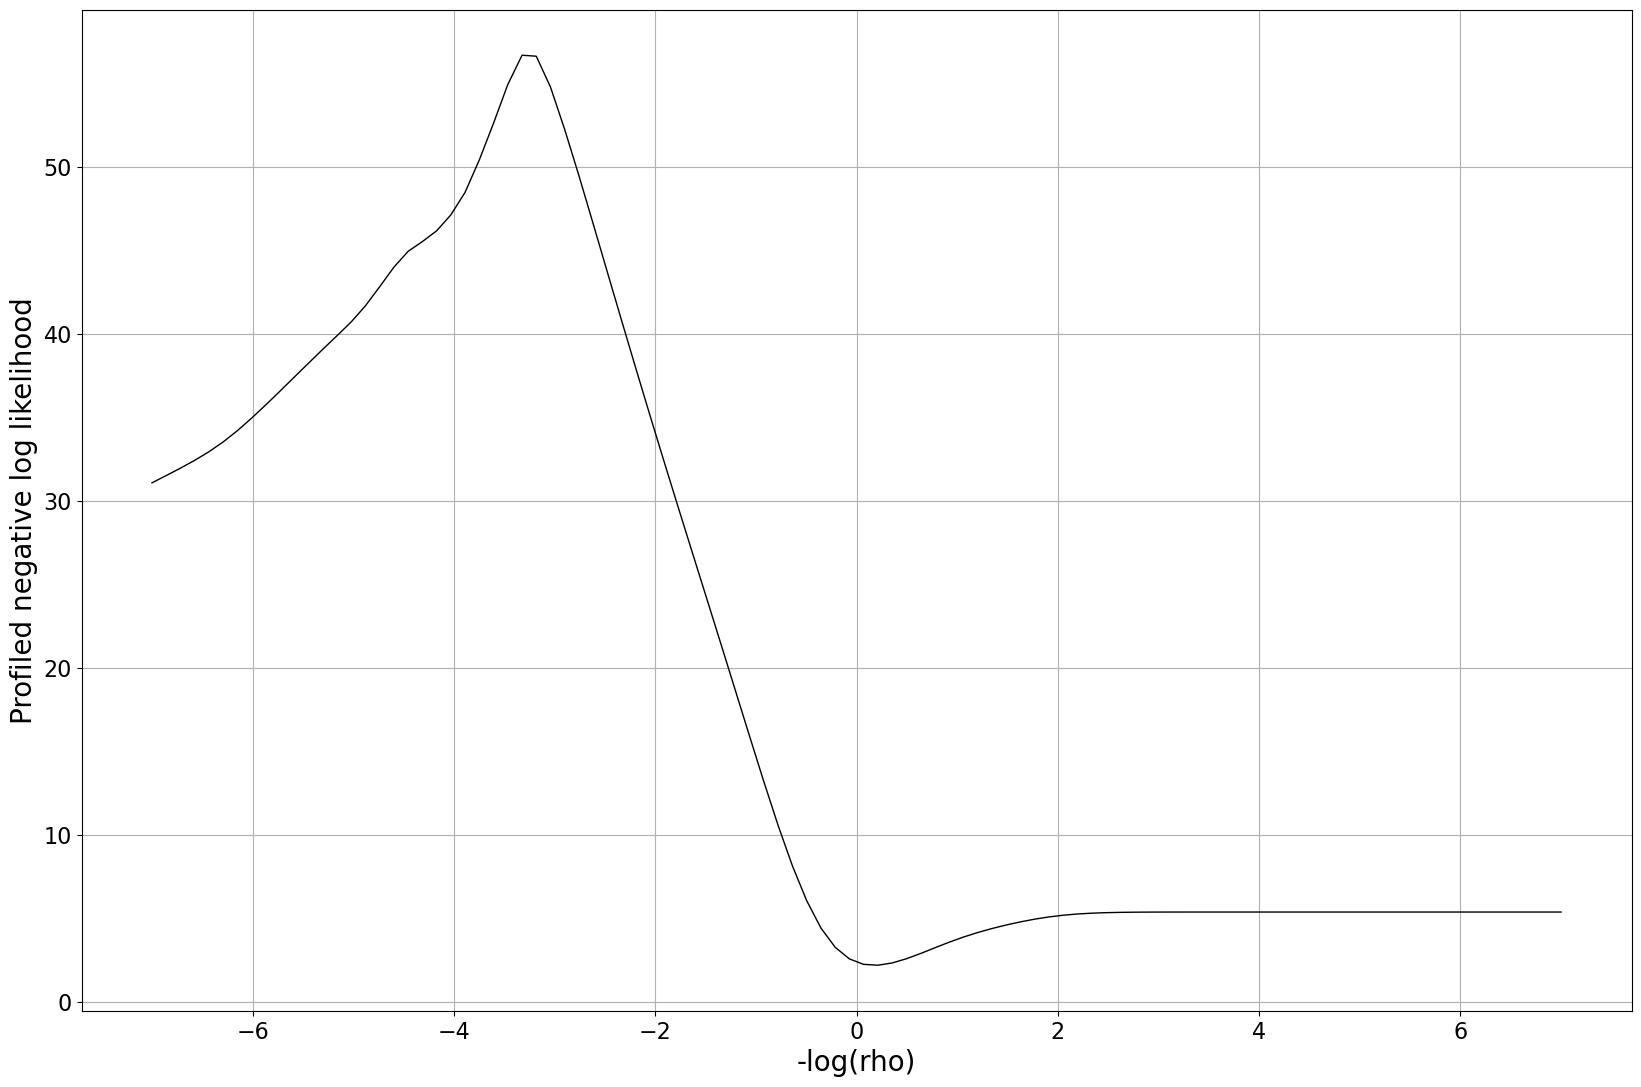

In [13]:
log_scale = False
if len(X_observed[0]) == 1:
    results_visualization.plot_profiled_negative_log_likelihood_evolution_1D(log_scale)
if len(X_observed[0]) == 2: 
    if plot_type_2D == "3D":
        results_visualization.plot_profiled_negative_log_likelihood_evolution_2D_3D(log_scale)
    if plot_type_2D == "heatmap":
        results_visualization.plot_profiled_negative_log_likelihood_evolution_2D_heatmap(log_scale)
if len(X_observed[0]) > 2:
    results_visualization.plot_profiled_negative_log_likelihood_evolution_nD(log_scale)

##### 6.2.3 - Profiled PVA negative log likelihood

We have $\hat{\sigma}_f^2 = \frac{f(\boldsymbol{X}_{train})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} Diag(k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1})^{-1} k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})}{n}$ and $l(\boldsymbol{\theta}) = \frac{f(\boldsymbol{X}_{train})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})}{\hat{\sigma}_f^2} + log \left(\left|\hat{\sigma}_f^2 k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})\right| \right)$.

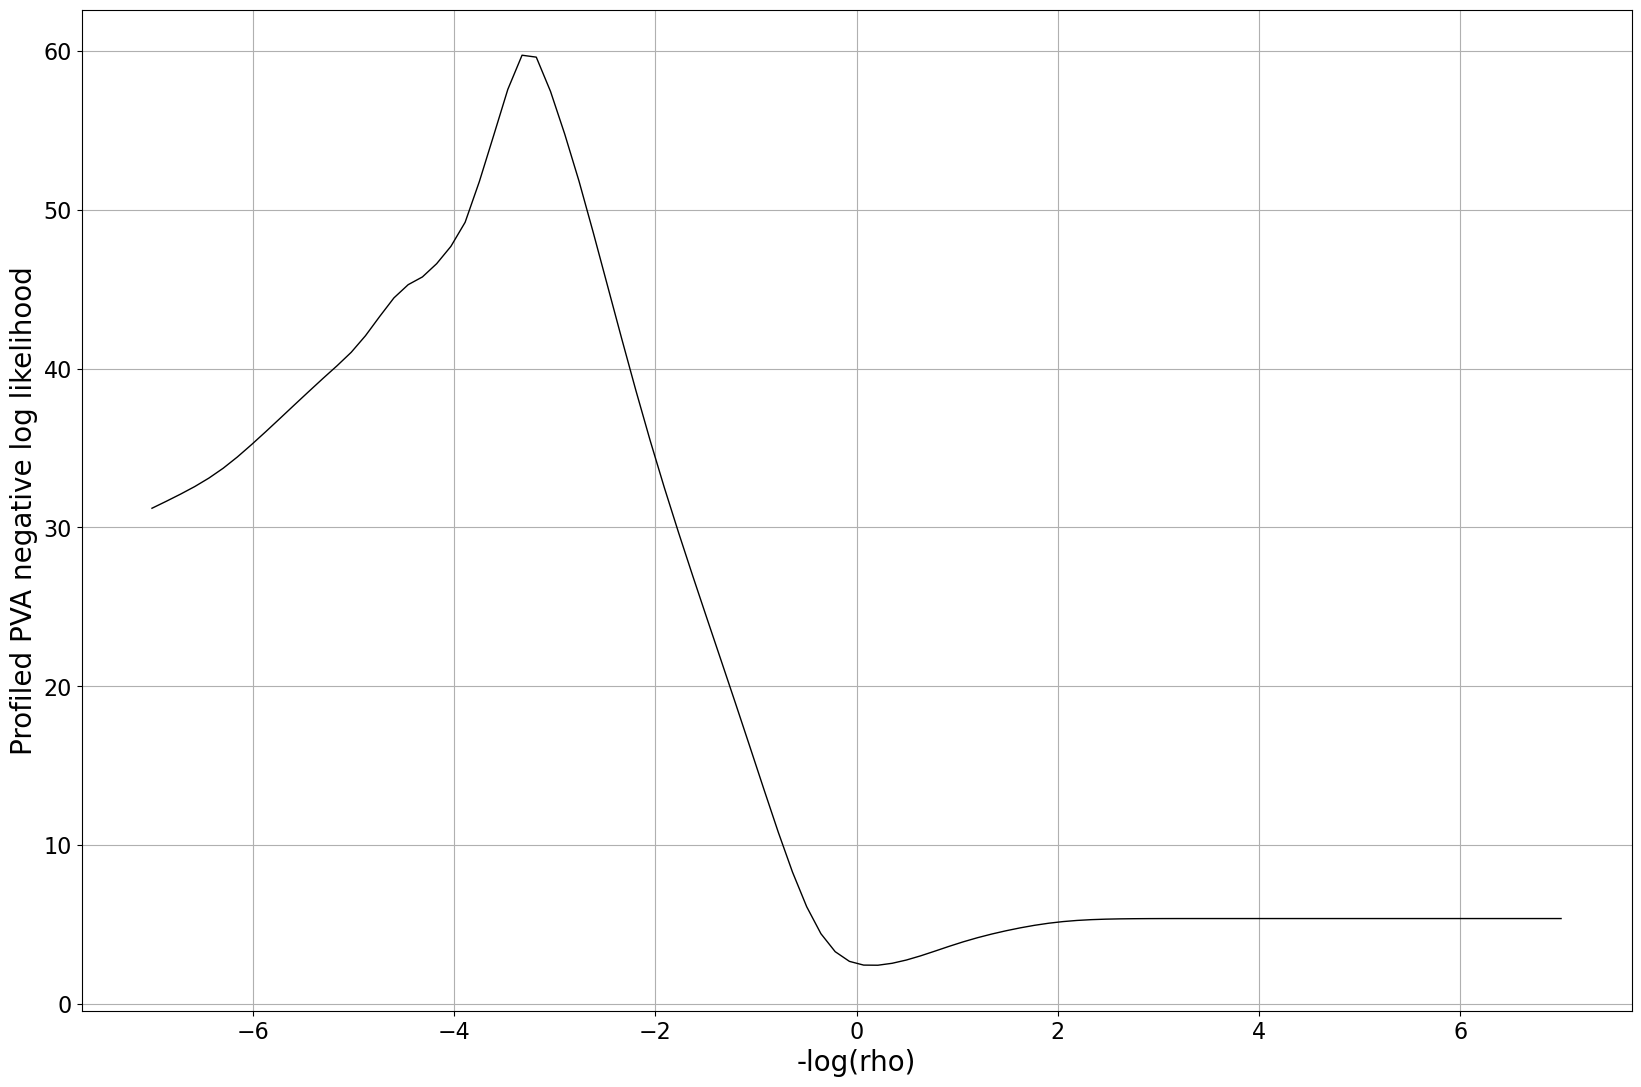

In [14]:
log_scale = False
if len(X_observed[0]) == 1:
    results_visualization.plot_profiled_pva_negative_log_likelihood_evolution_1D(log_scale)
if len(X_observed[0]) == 2: 
    if plot_type_2D == "3D":
        results_visualization.plot_profiled_pva_negative_log_likelihood_evolution_2D_3D(log_scale)
    if plot_type_2D == "heatmap":
        results_visualization.plot_profiled_pva_negative_log_likelihood_evolution_2D_heatmap(log_scale)
if len(X_observed[0]) > 2:
    results_visualization.plot_profiled_pva_negative_log_likelihood_evolution_nD(log_scale)

##### 6.2.4 - Mean square error

We have $l(\boldsymbol{\theta}) = f(\boldsymbol{X}_{train})^T k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} Diag(k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1})^{-2} k_{\boldsymbol{\theta}}(\mathbf{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})$.

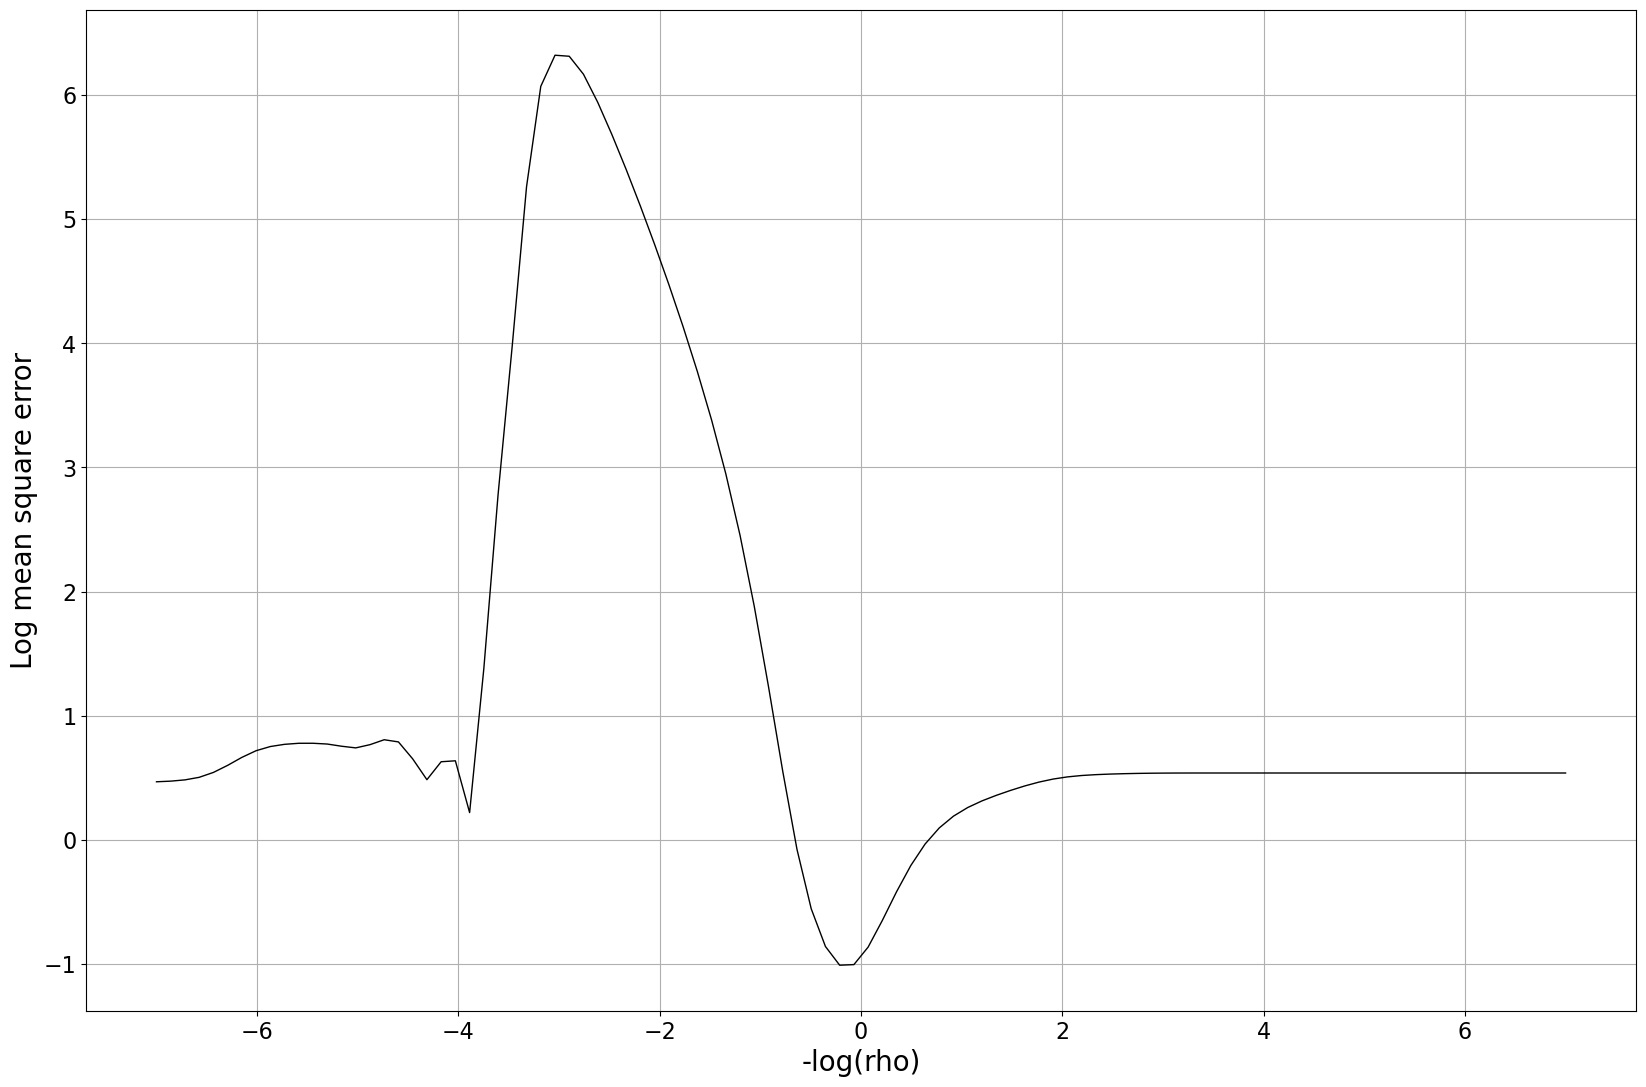

In [15]:
log_scale = True
if len(X_observed[0]) == 1:
    results_visualization.plot_mean_square_error_evolution_1D(log_scale)
if len(X_observed[0]) == 2: 
    if plot_type_2D == "3D":
        results_visualization.plot_mean_square_error_evolution_2D_3D(log_scale)
    if plot_type_2D == "heatmap":
        results_visualization.plot_mean_square_error_evolution_2D_heatmap(log_scale)
if len(X_observed[0]) > 2:
    results_visualization.plot_mean_square_error_evolution_nD(log_scale)

# 7 - Reliability

### 7.1 - ECP

We compute the Empirical Coverage Probability (ECP) $ECP(1-\alpha) = \frac{1}{N_{test}} \sum_{n=1}^{N_{test}} \mathbb{1}_{\{f(\boldsymbol{x}_n) \in \mathcal{I}_{1 - \alpha}(\boldsymbol{x}_n)\}}$ to estimate $\mathbb{P}_{\mathcal{X}}(f(\boldsymbol{x}) \in \mathcal{I}_{1 - \alpha}(\boldsymbol{x}))$, with $\mathcal{I}_{1 - \alpha}(\boldsymbol{x}_n) = [m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n) \pm q_{1-\frac{\alpha}{2}} \sqrt{k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n, \boldsymbol{x}_n))}$

The confidence interval around the ECP is computed in the probability space of $\mathcal{X}$, where all predictions are independent. If the uncertainty quantification is reliable, we should have:
- $\mathbb{E} \left[ ECP(1-\alpha) \right] \geq 1 - \alpha$.
- $V \left[ ECP(1-\alpha) \right] = \frac{\alpha(1 - \alpha)}{N_{test}}$.

This is true for an estimation on a test set.

##### 7.1.1 - Train

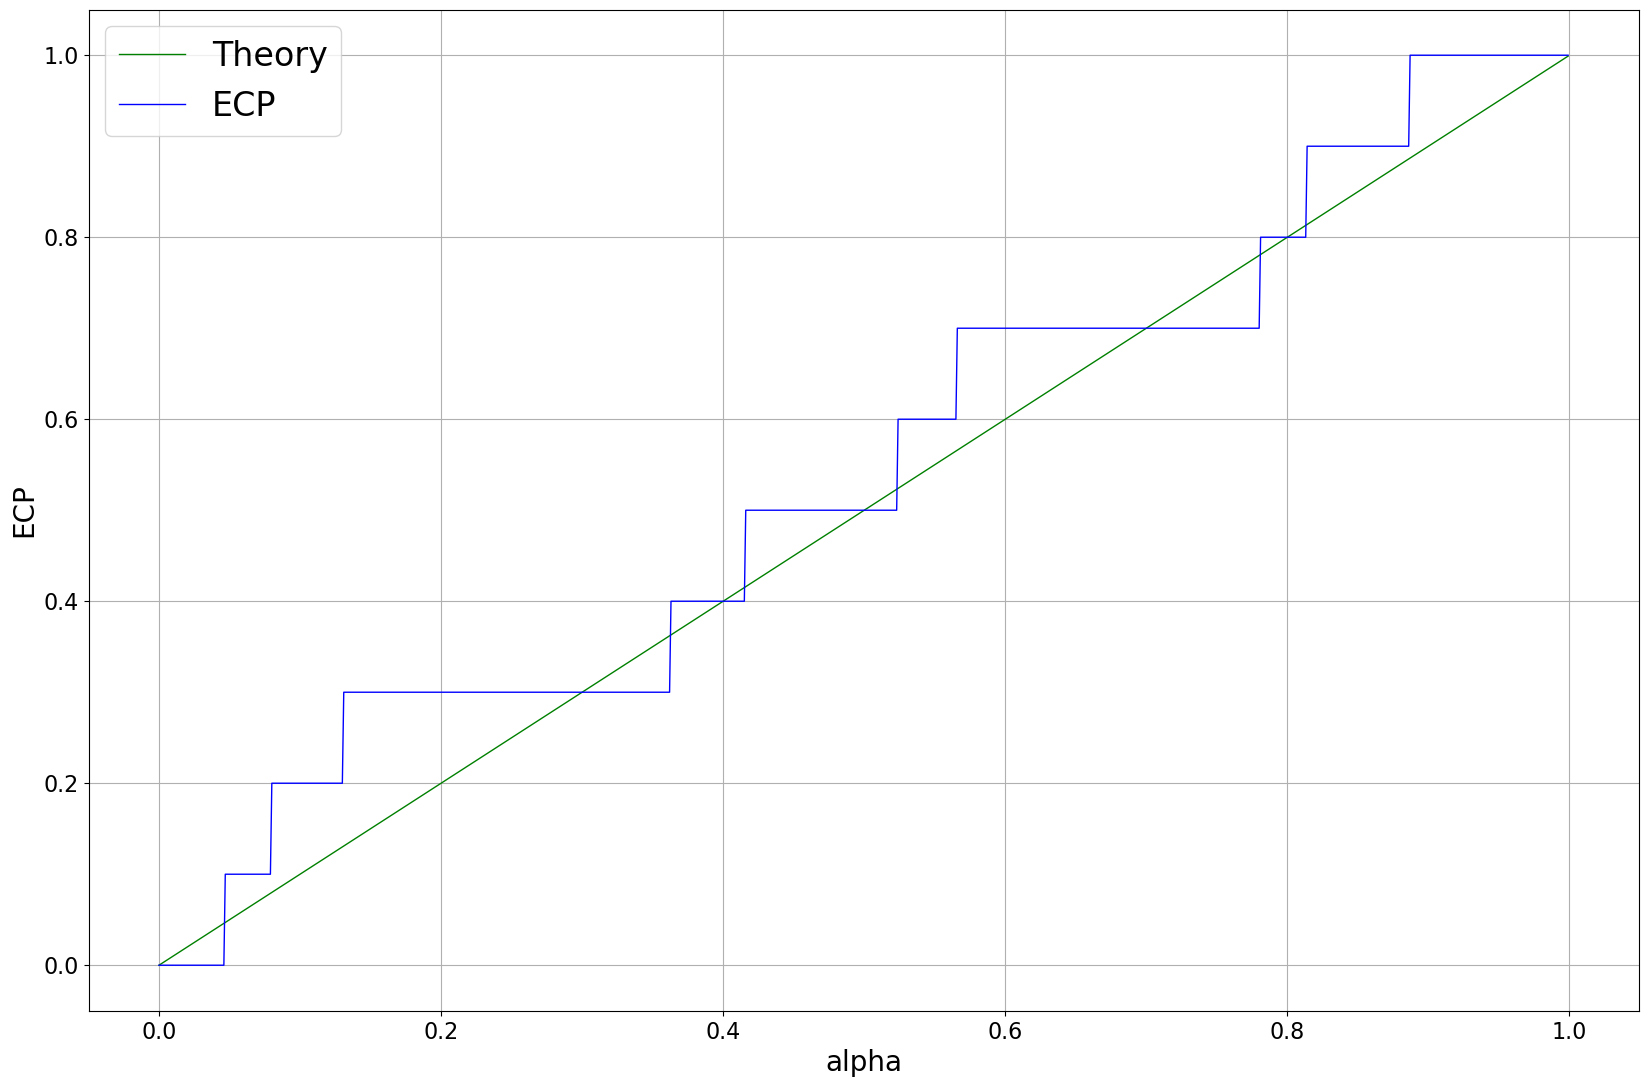

In [16]:
results_visualization.plot_empirical_coverage_probability_assuming_reliability("Train")

##### 7.1.2 - Test

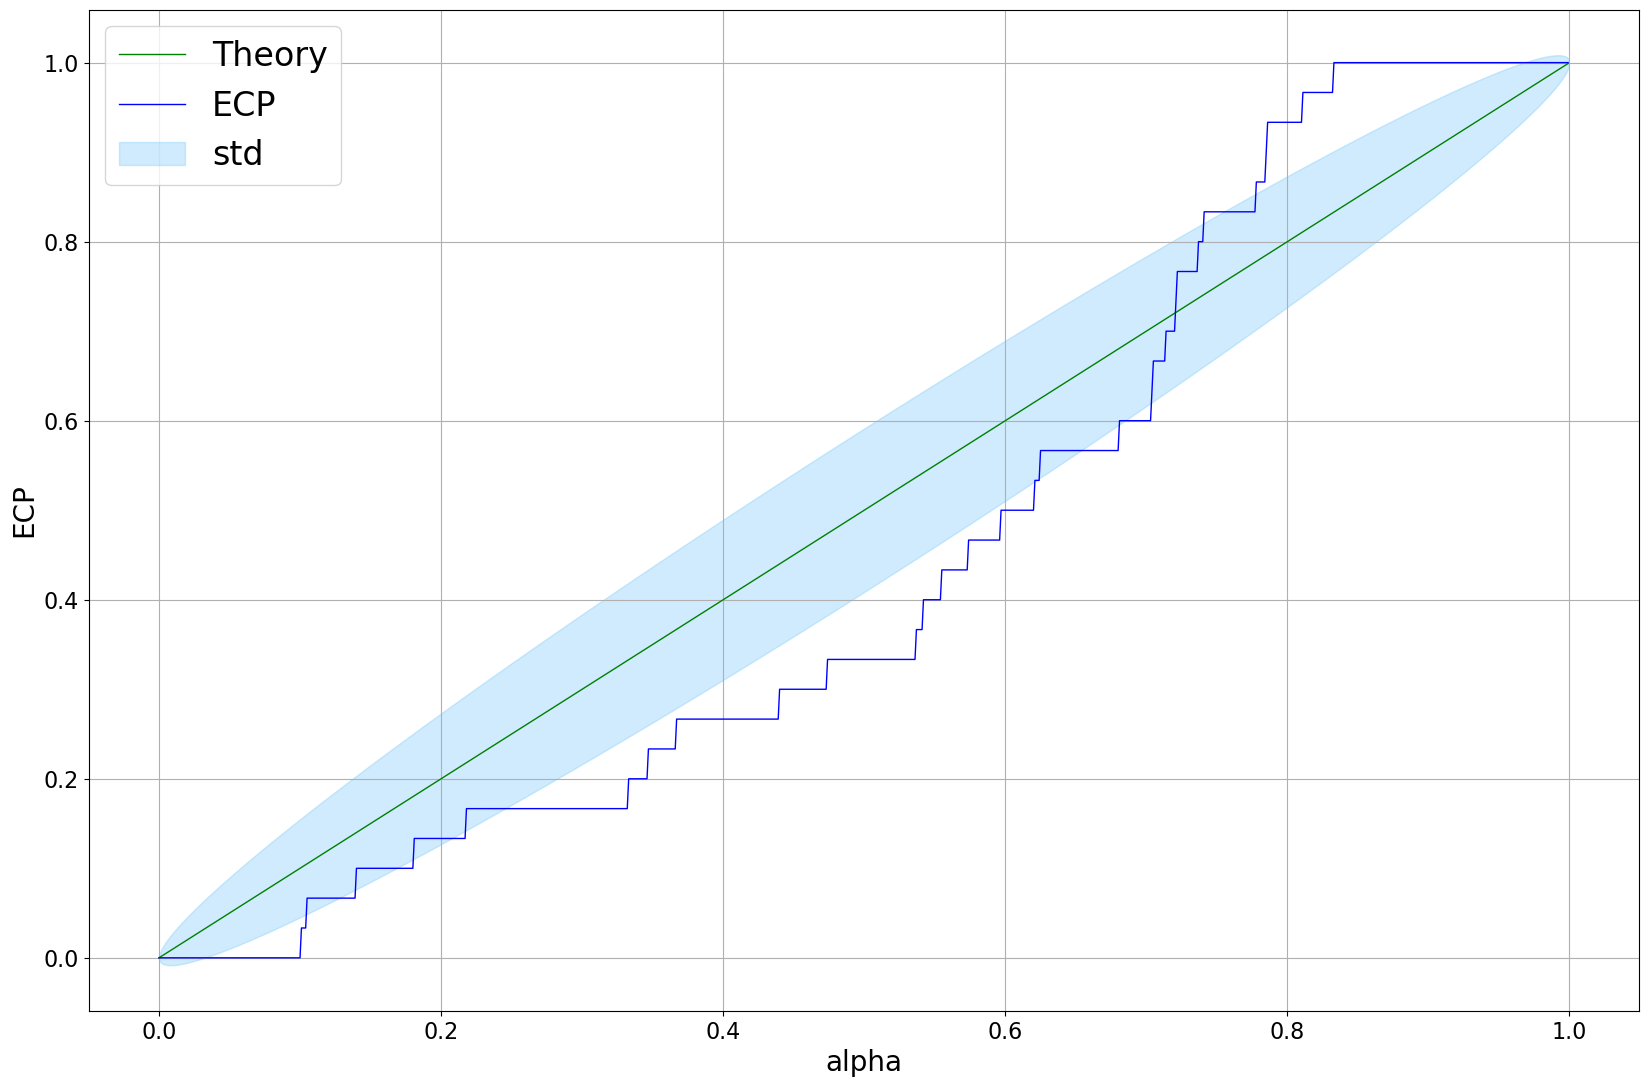

In [17]:
results_visualization.plot_empirical_coverage_probability_assuming_reliability("Test")

### 7.2 -PVA

We compute the Predictive Variance Adequacy (PVA) $PVA = \frac{1}{N_{test}} \sum_{n=1}^{N_{test}} \frac{(f(\boldsymbol{x}_n) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n))^2}{k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n, \boldsymbol{x}_n))}$ to estimate the average normalized error. If the uncertainty quantification is reliable, we should have:
- $\mathbb{E} \left[ PVA \right] \leq 1 $.
- $V \left[ PVA \right] = \frac{2}{N_{test}}$.

This is true for an estimation on a test set.

##### 7.2.1 - Train

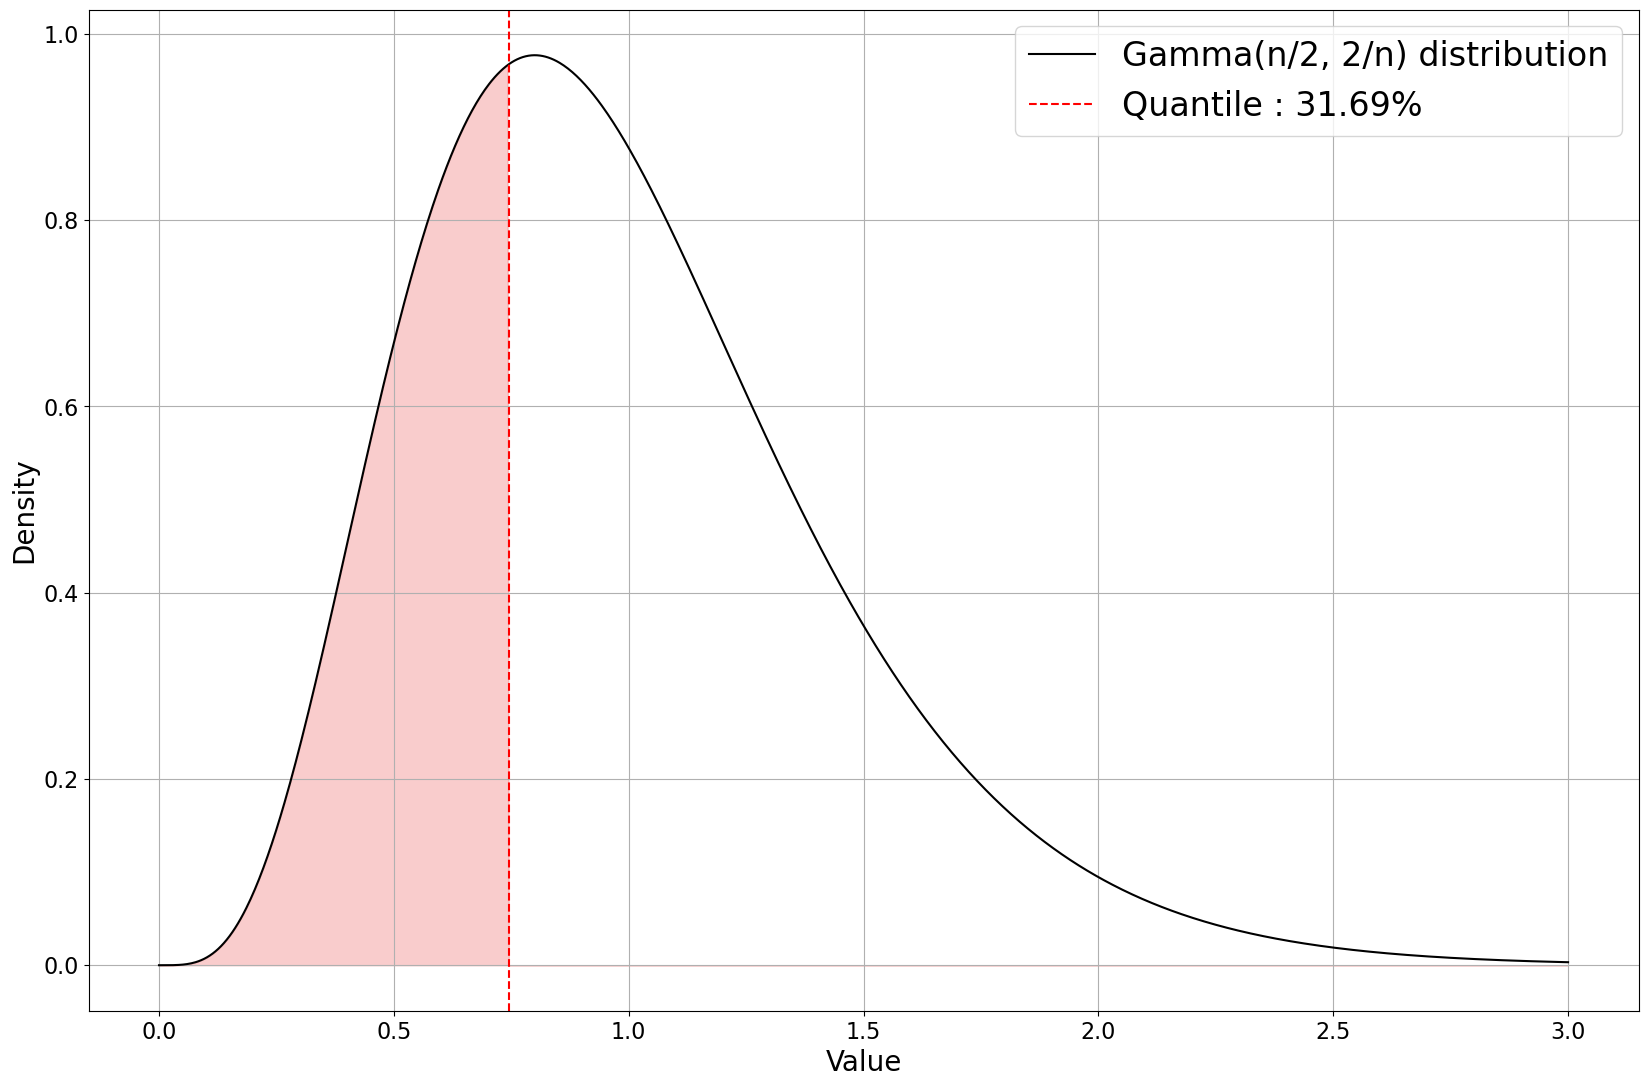

In [18]:
results_visualization.plot_predictive_variance_adequacy_distribution_assuming_reliability("Train")

##### 7.2.2 - Test

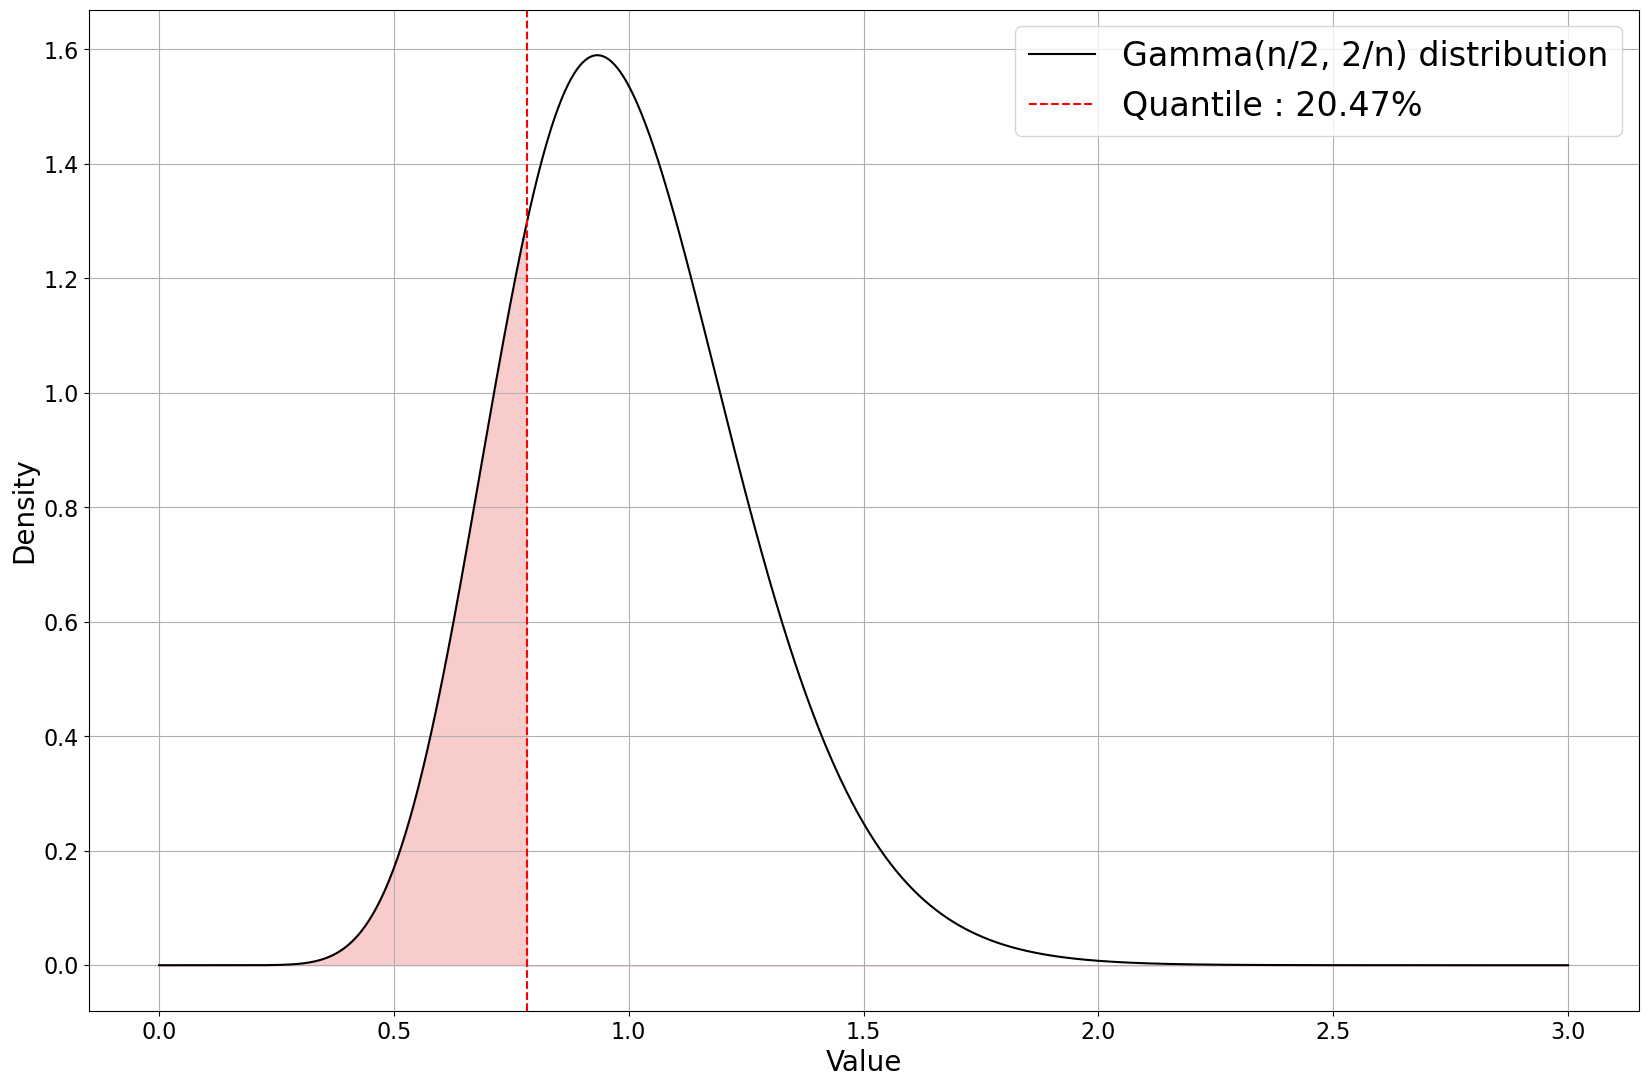

In [19]:
results_visualization.plot_predictive_variance_adequacy_distribution_assuming_reliability("Test")

### 7.3 - Nomalized prediction errors

##### 7.3.1 - Train

We now plot the empirical distribution of each normalized error $\frac{f(\boldsymbol{x}_n) - m^{-n}_{\boldsymbol{\theta}}(\boldsymbol{x}_n)}{\sqrt{k^{-n}_{\boldsymbol{\theta}}(\boldsymbol{x}_n, \boldsymbol{x}_n))}}$ computed in LOO on the train set.

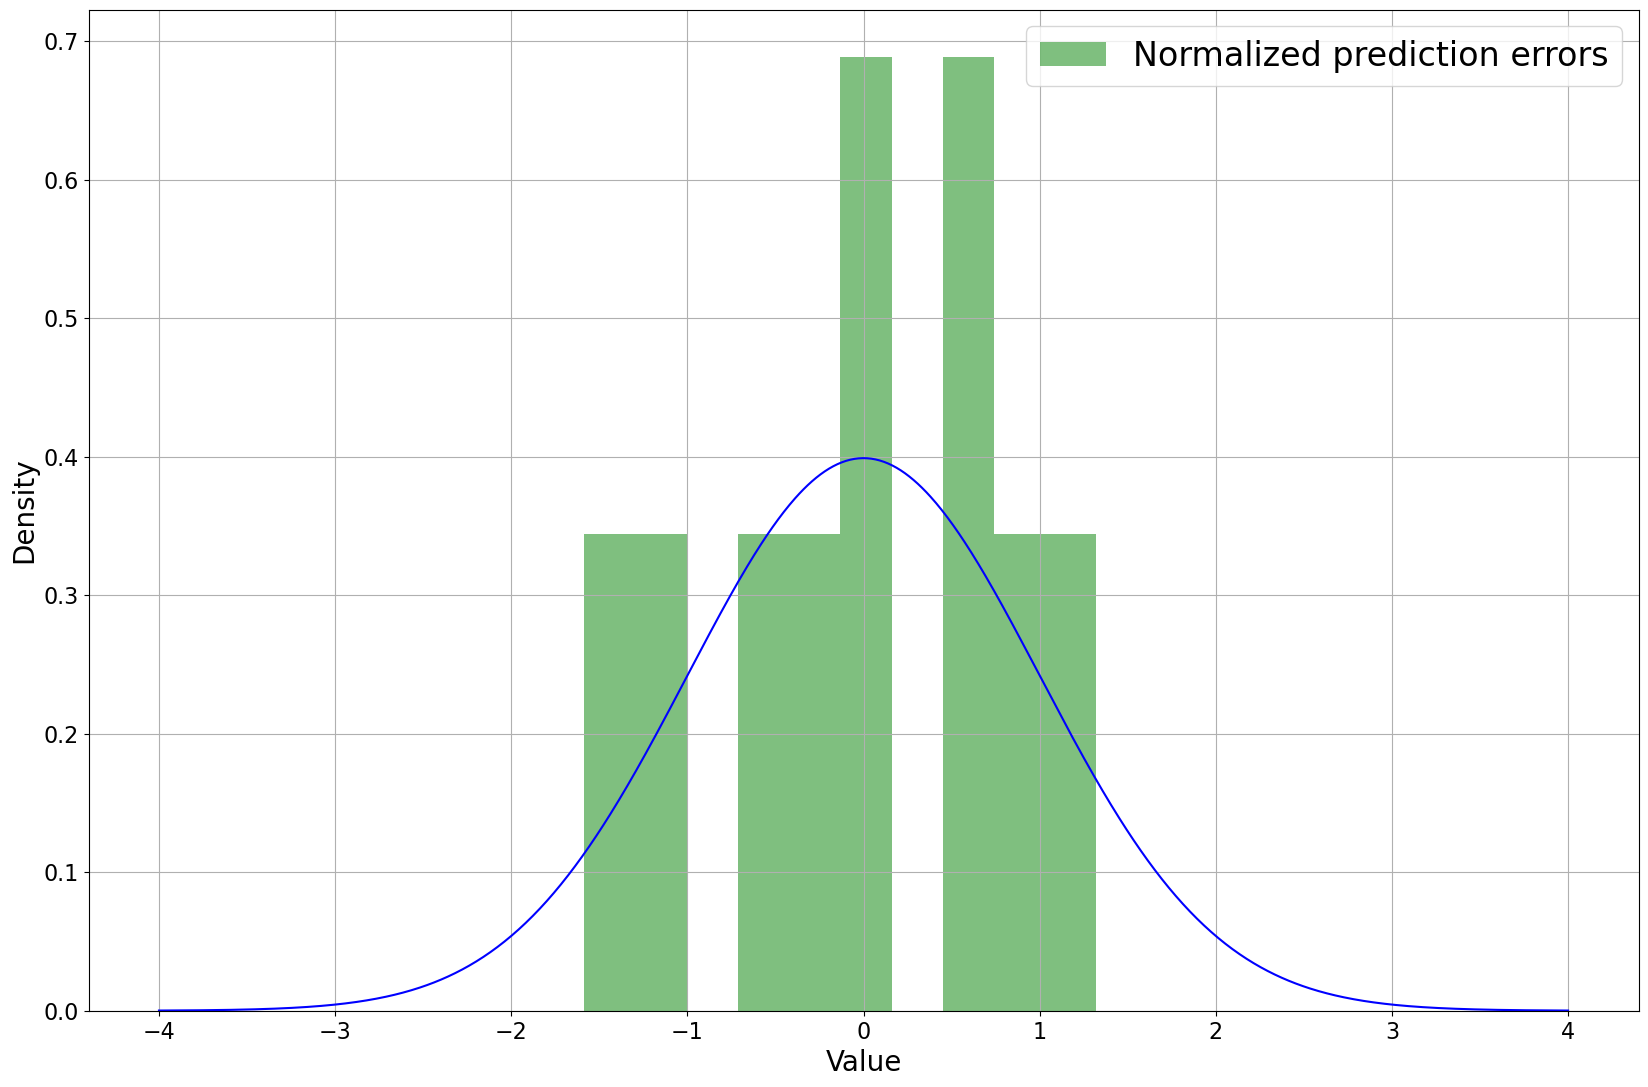

In [20]:
results_visualization.plot_normalized_prediction_errors("Train")

##### 7.3.2 - Test

We now plot the empirical distribution of each normalized error $\frac{f(\boldsymbol{x}_n) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n)}{\sqrt{k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n, \boldsymbol{x}_n))}}$ computed on the test set.

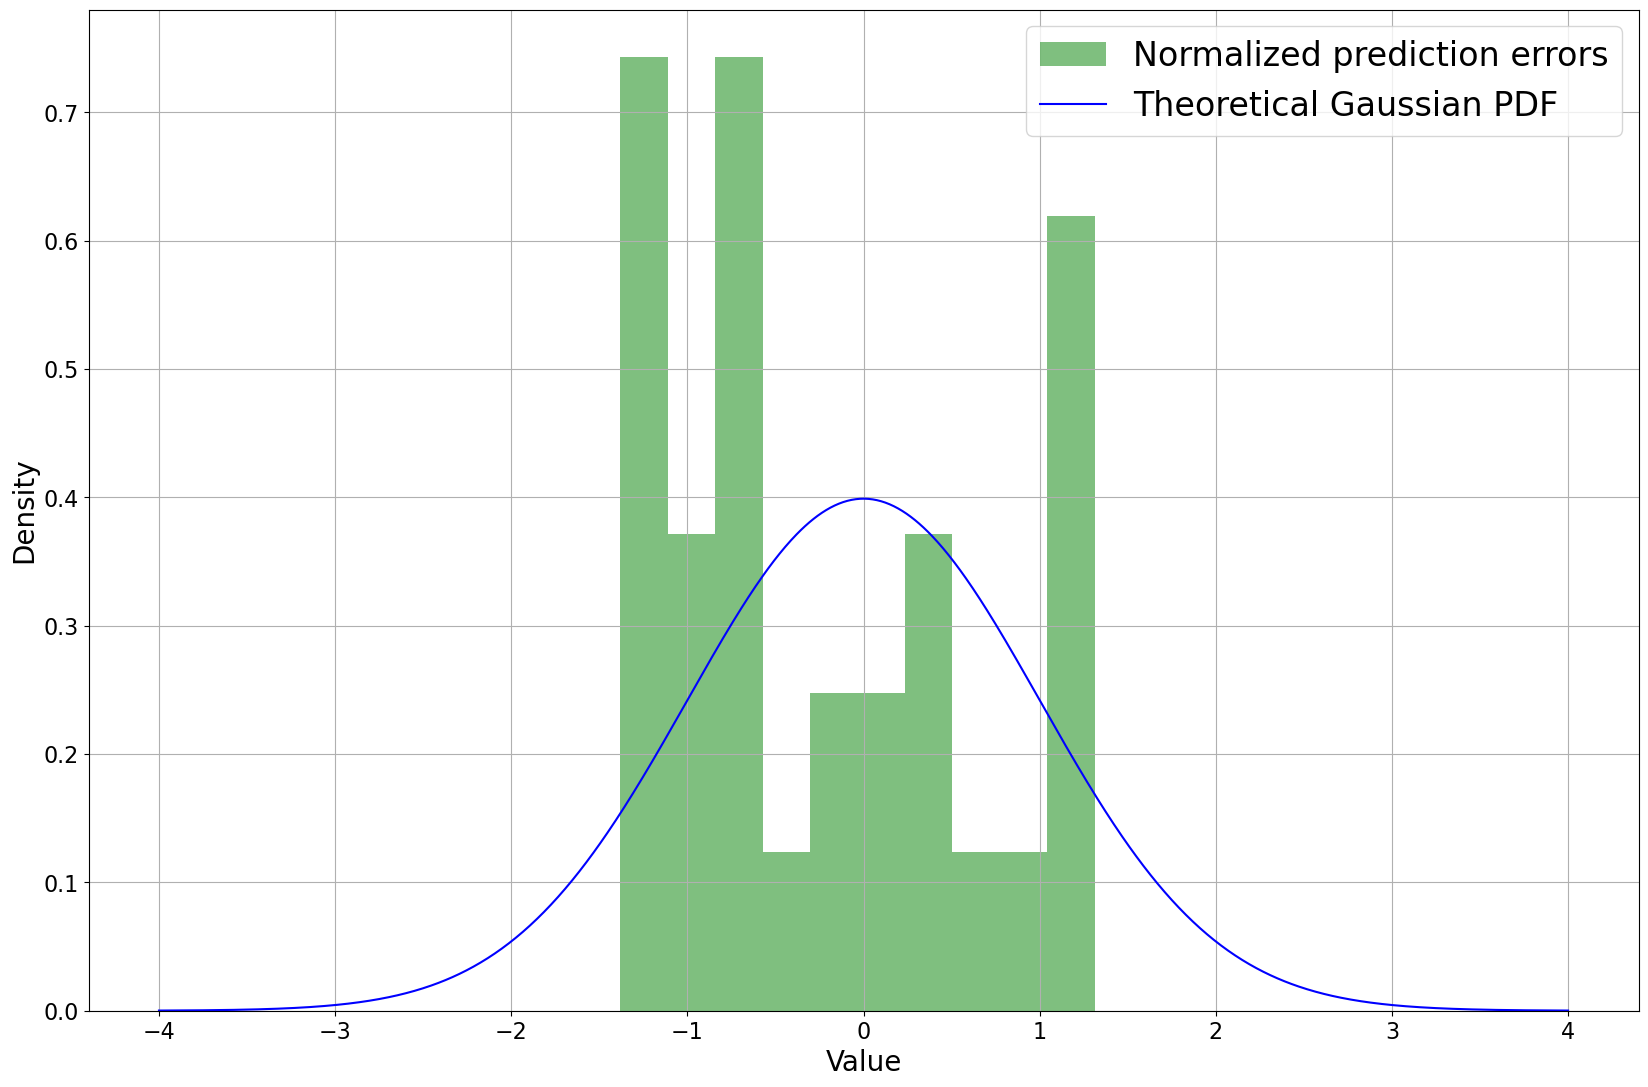

In [21]:
results_visualization.plot_normalized_prediction_errors("Test")

# 8 - Gaussianity

### 8.1 - Train

The Gaussian process prior assumes that our centered function $f(\boldsymbol{X}_{train}) \sim \mathcal{N}(\boldsymbol{0}, k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train}))$. It implies that $\boldsymbol{Z}_{train} = k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-\frac{1}{2}} f(\boldsymbol{X}_{train}) \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$. We are going to look how relevant this hypothesis is.

##### 8.1.1 - Whitened data

We first look at each component $z_n$ of the vector $\boldsymbol{Z}_{train}$. If the prior Gaussian assumption holds, $\forall n \in [1, N_{train}], z_n \sim \mathcal{N}(0, 1)$. We plot the empirical distribution of $z_1,...,z_{N_{train}}$.

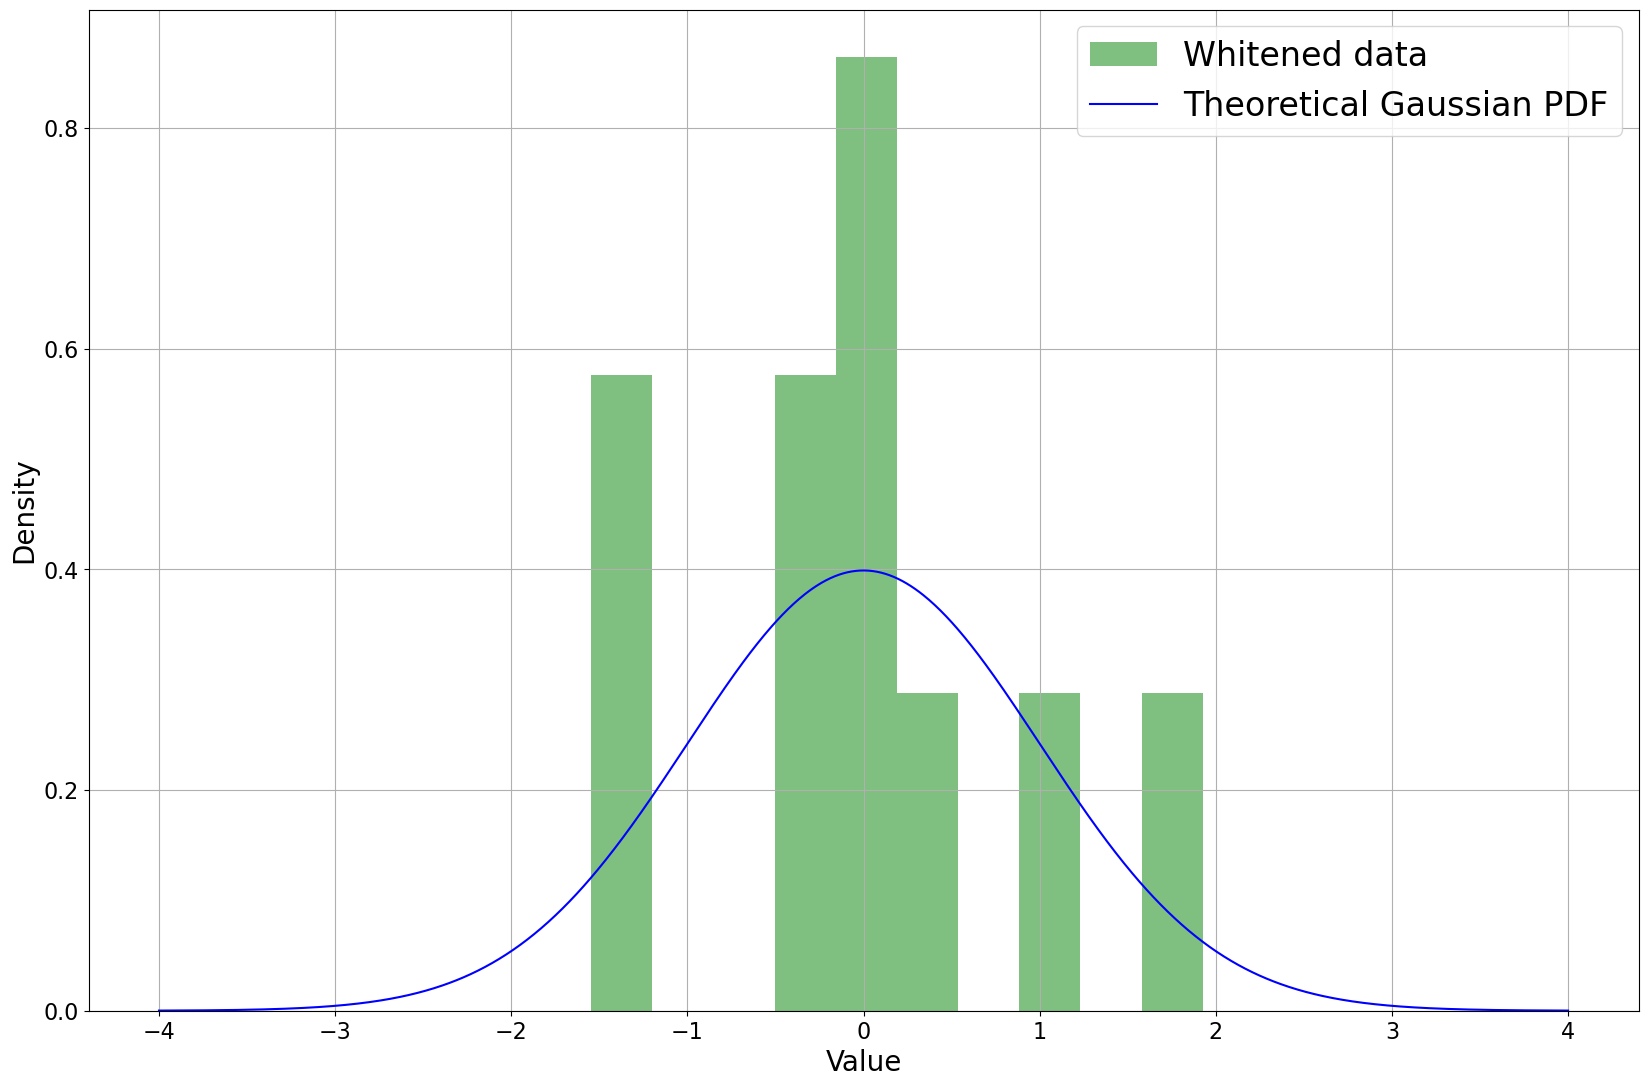

In [22]:
results_visualization.plot_whitened_data_assuming_gaussianity("Train")

##### 8.1.2 - Mahalanobis distance distribution

We now look at the Mahalanobis distance of the vector $\boldsymbol{Z}_{train}$. If prior Gaussian assumption holds, we have $\boldsymbol{Z}_{train}^T \boldsymbol{Z}_{train} \sim \chi^2(N_{train})$.

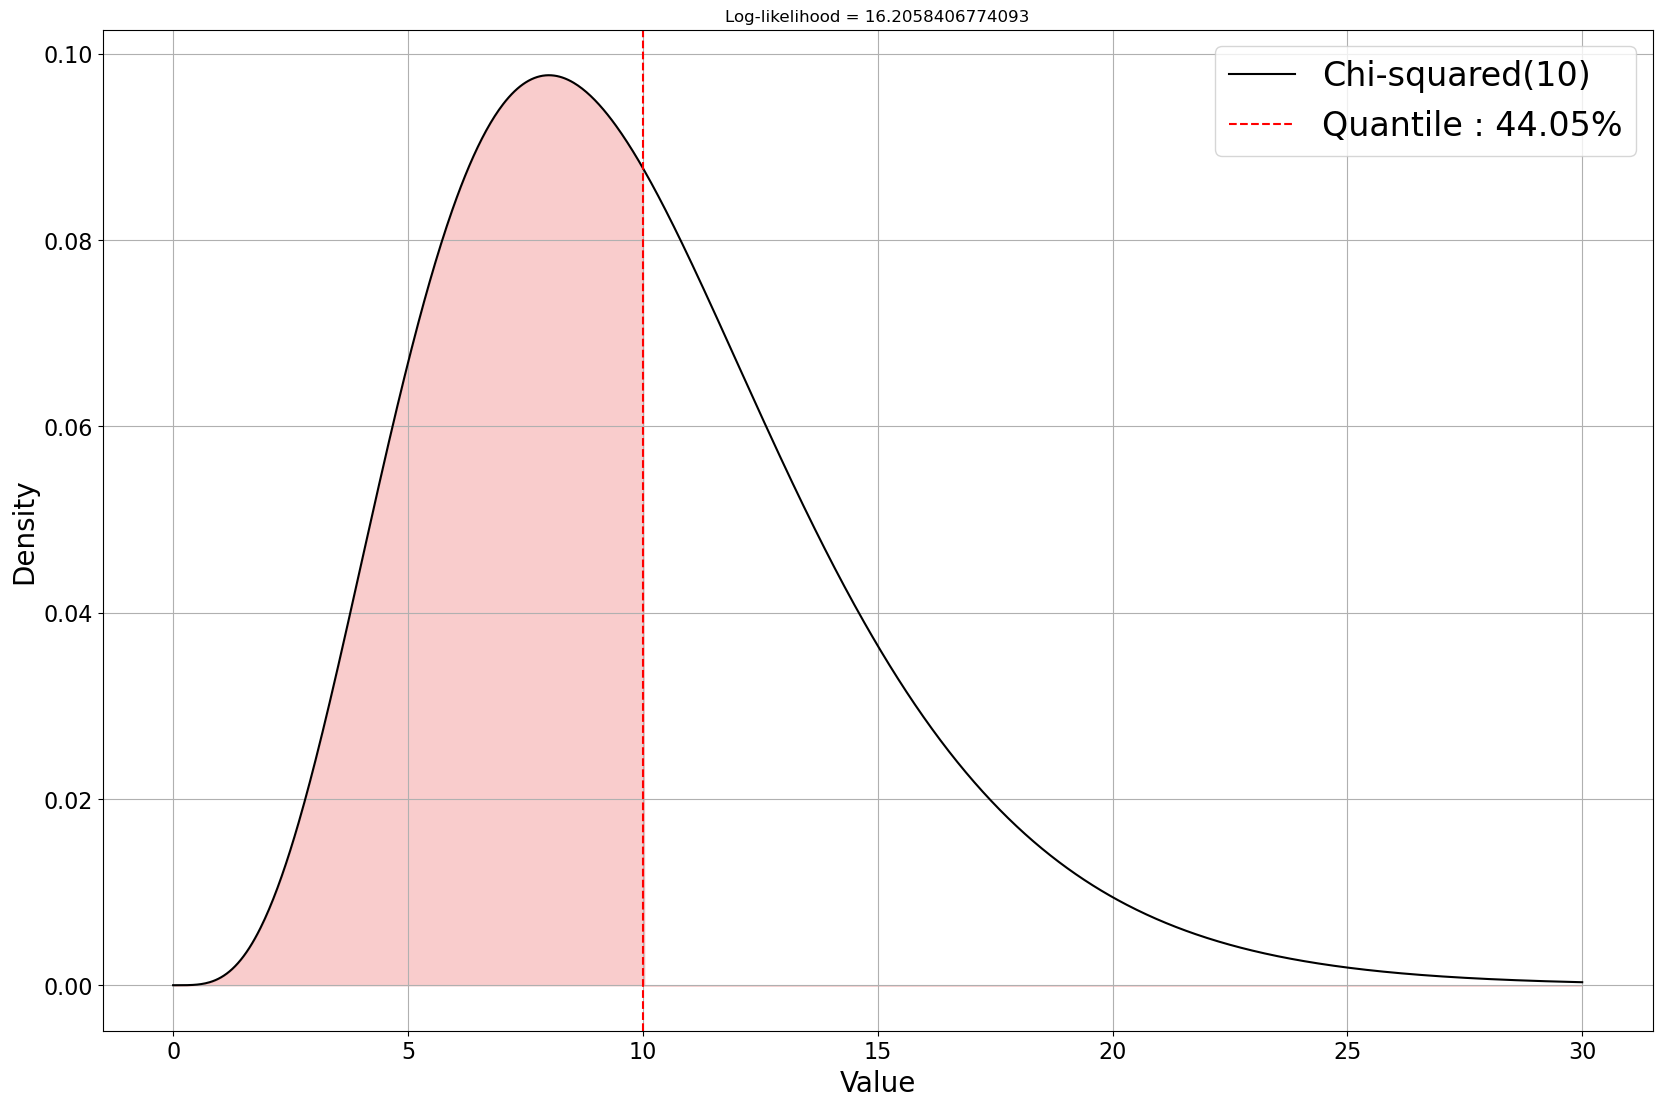

In [23]:
results_visualization.plot_mahalanobis_distance_distribution_assuming_gaussianity("Train")

##### 8.1.3 - Equivalent normal observation

We plot the observation of a 1-D normal distribution $\mathcal{N}(0, 1)$ that would have the same Mahalanobis distance.

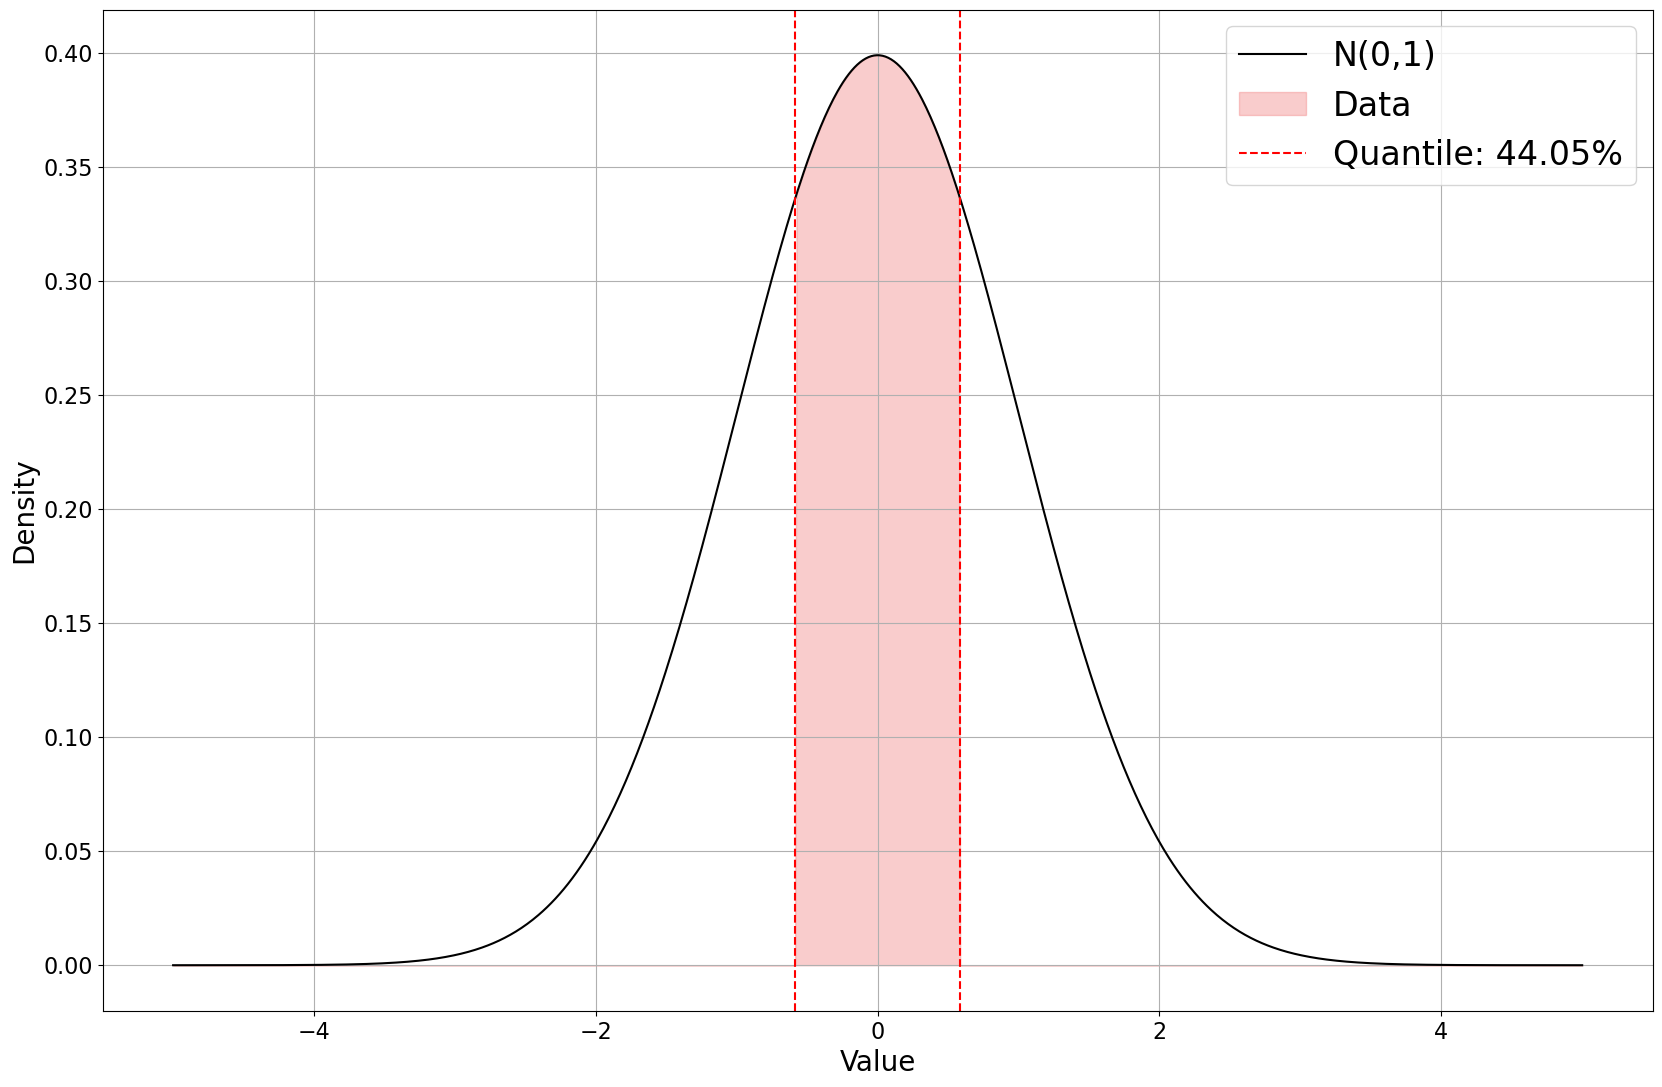

In [24]:
results_visualization.plot_equivalent_normal_observation_assuming_gaussianity("Train")

##### 8.1.4 - ECP

As for reliability, we compute in Leave-One-Out (LOO) the ECP. The only difference is we now compute the confidence interval in the probability space of the Gaussian process, taking into account the correlations between the predictions. Since there is no close-form expression of this CI, we only provide a lower bound, assuming independent predictions. 

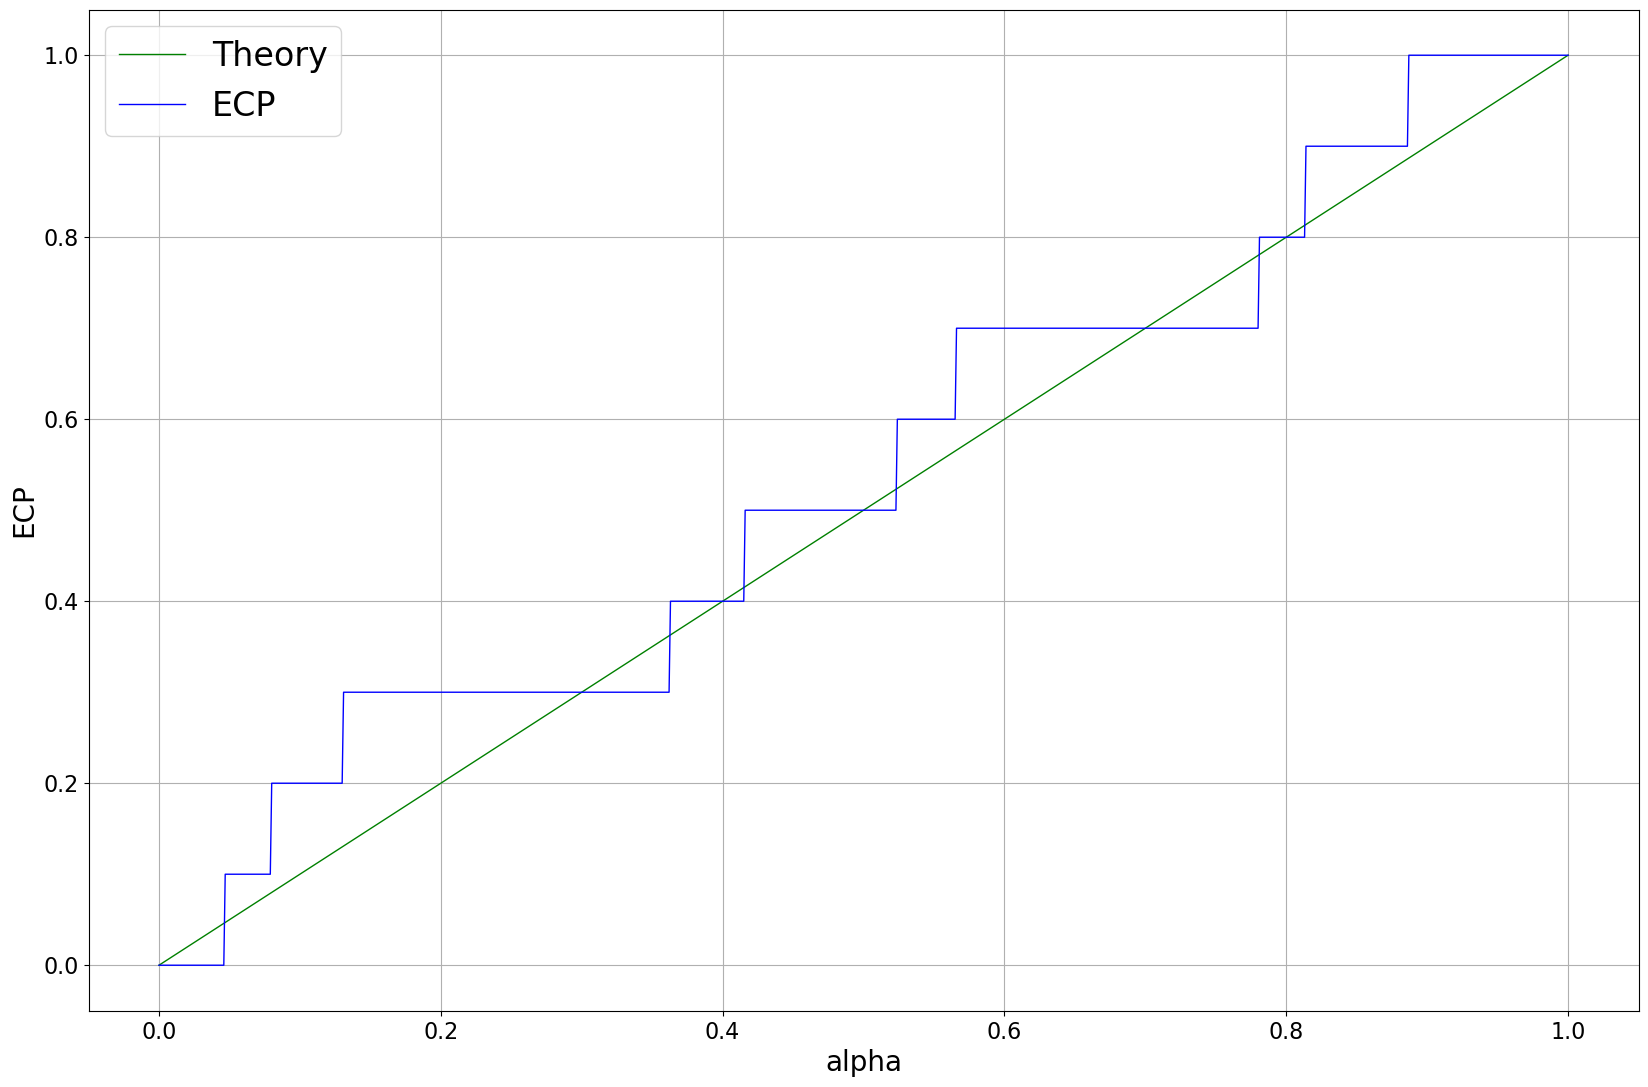

In [25]:
results_visualization.plot_empirical_coverage_probability_assuming_gaussianity("Train")

##### 8.1.5 - PVA

We compute the Predictive Variance Adequacy (PVA) $PVA = \frac{1}{N_{train}} \sum_{n=1}^{N_{train}} \frac{(f(\boldsymbol{x}_n) - m^{-n}_{\boldsymbol{\theta}}(\boldsymbol{x}_n))^2}{k^{-n}_{\boldsymbol{\theta}}(\boldsymbol{x}_n, \boldsymbol{x}_n))}$ in LOO. If the prior Gaussian assumption holds, we should have $PVA \sim \sum_{n=1}^{N_{train}} \frac{\lambda_n}{N_{train}} \chi^2(1)$ with $\lambda_1,...,\lambda_{N_{train}}$ the eigenvalues of $Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} \right)^{-\frac{1}{2}} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} \right)^{-\frac{1}{2}} = \boldsymbol{P}_{train} \boldsymbol{D}_{train} \boldsymbol{P}_{train}^T$. $\boldsymbol{P}_{train}$ is chosen to be an orthogonal matrix.

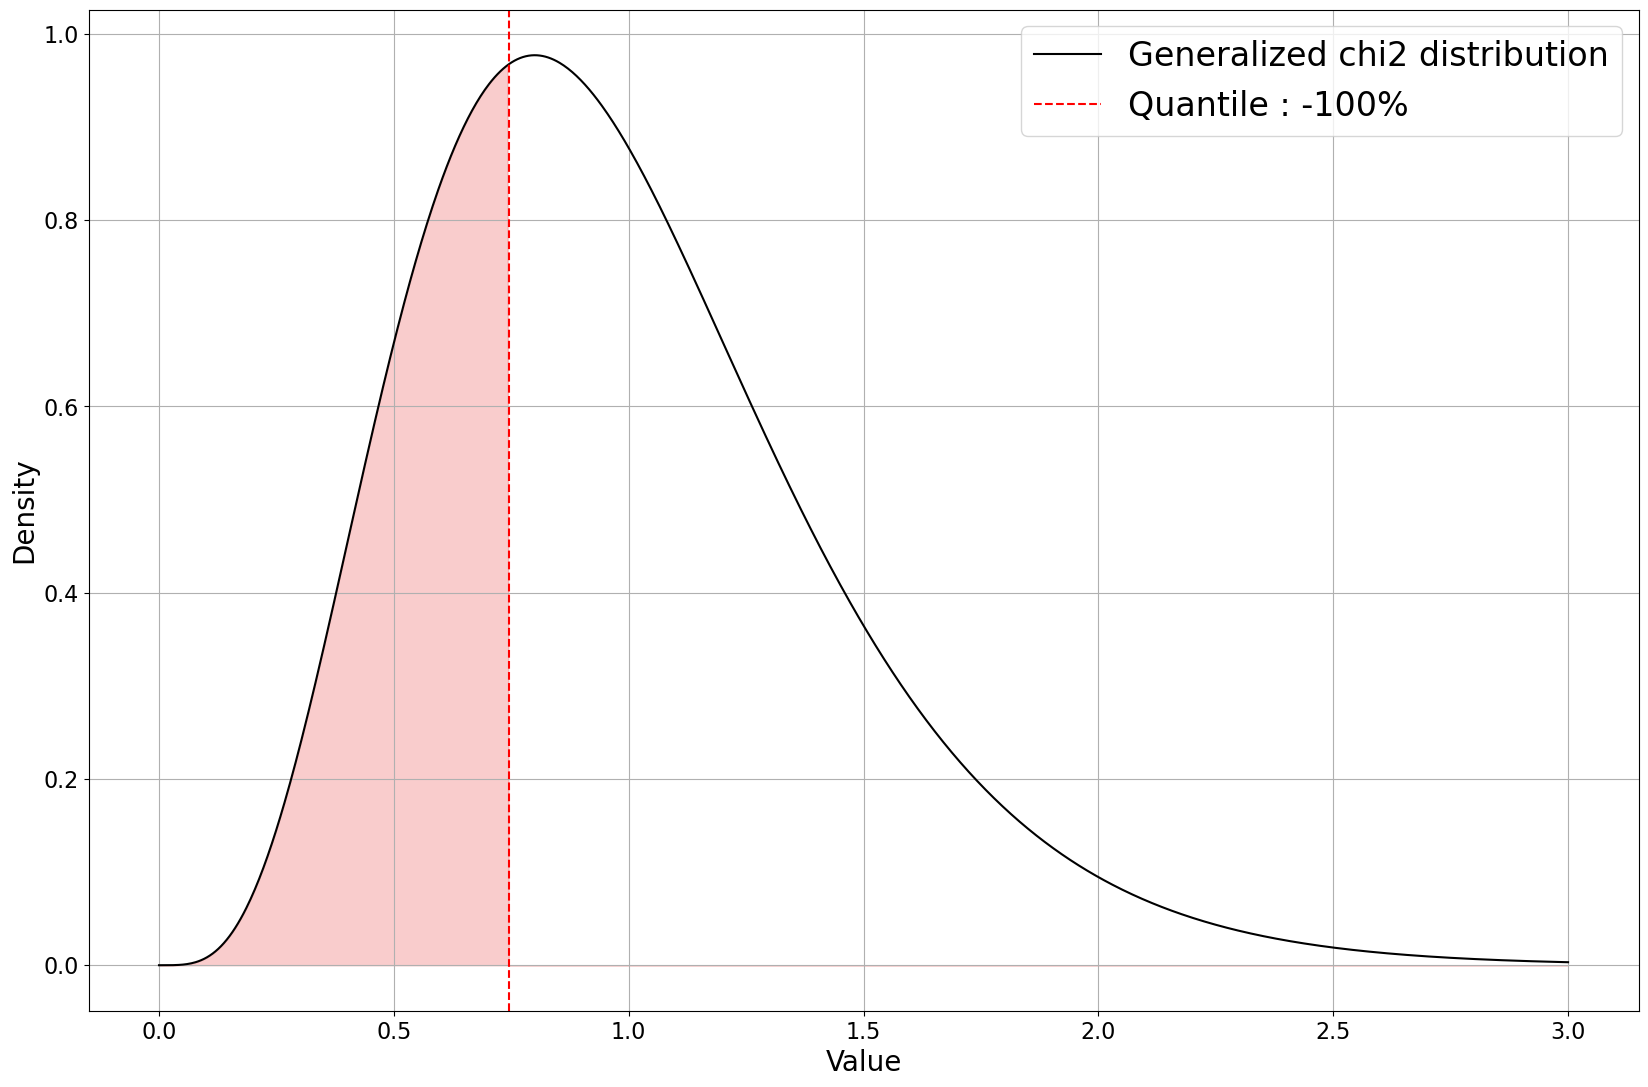

In [26]:
results_visualization.plot_predictive_variance_adequacy_assuming_gaussianity("Train")

##### 8.1.6 - Normalized prediction errors uncorrelated

One can notice that $PVA = ||Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} \right)^{-\frac{1}{2}} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})||^2 = ||\boldsymbol{P}_{train}^T Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} \right)^{-\frac{1}{2}} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})||^2$. We define:
- $\boldsymbol{Y}_{train} = Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} \right)^{-\frac{1}{2}} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})$.
- $\boldsymbol{W}_{train} = \boldsymbol{D}_{train}^{-\frac{1}{2}} \boldsymbol{P}_{train}^T Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} \right)^{-\frac{1}{2}} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{train}, \boldsymbol{X}_{train})^{-1} f(\boldsymbol{X}_{train})$.

Then:
- $PVA = \sum_{n=1}^{N_{train}} \boldsymbol{Y}_{train}^{(n)2}$ and under the prior Gaussian assumption, $\forall n \in [1, N_{train}], \boldsymbol{Y}_{train}^{(n)2} \sim \chi^2(1)$
- $PVA = \sum_{n=1}^{N_{train}} \lambda_n \boldsymbol{W}_{train}^{(n)2}$ and under the prior Gaussian assumption, $\forall n \in [1, N_{train}], \boldsymbol{W}_{train}^{(n)2} \sim \chi^2(1)$

We decorrelated the errors. The usual correlated ECP computed in LOO on train set can then be written as $ECP(1 - \alpha) = \frac{1}{N_{train}} \sum_{n=1}^{N_{train}} \mathbb{1}_{\{ |\boldsymbol{Y}_{train}^{(n)}| \leq q_{1 - \frac{\alpha}{2}}\}}$. One could then naturally extend to a new uncorrelated ECP computed in LOO on train set by $NECP(1 - \alpha) = \frac{1}{N_{train}} \sum_{n=1}^{N_{train}} \lambda_n \mathbb{1}_{\{ |\boldsymbol{W}_{train}^{(n)}| \leq q_{1 - \frac{\alpha}{2}}\}}$. The difference is that now, if the prior Gaussian assumption holds, $\boldsymbol{W}_{train} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{D}_{train})$. The components are independent, so we call this new ECP uncorrelated ECP. Unlike correlated ECP, we can compute exact confidence intervals around the ECP in the probability space of the Gaussian process.

We now plot the empirical distribution of each uncorrelated normalized error $\boldsymbol{W}_{train}^{(n)}$ and also show the associated $\lambda_n$. A high value of $\lambda_n$ indicates that many predictions in LOO on the train set share this error.

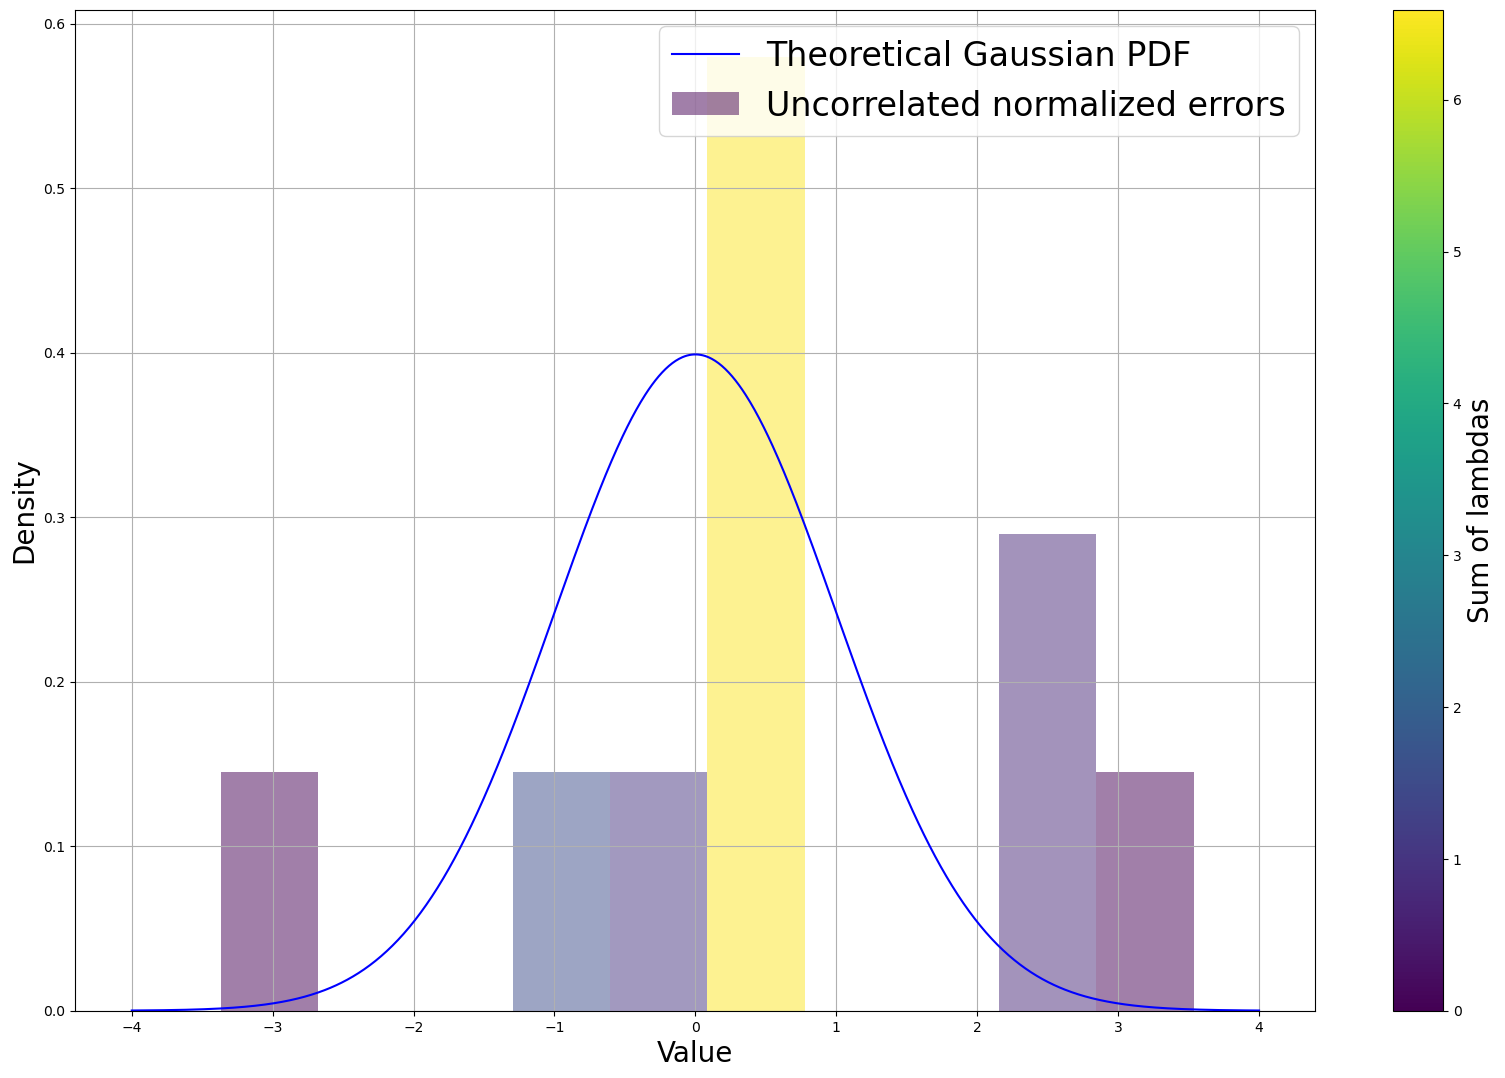

In [27]:
results_visualization.plot_normalized_prediction_errors_uncorrelated_assuming_gaussianity("Train")

##### 8.1.7 - $\lambda_n$ empirical distribution

Finally, we plot the empirical distribution of the eigenvalues $\lambda_n$ to see to what extent the errors are correlated.

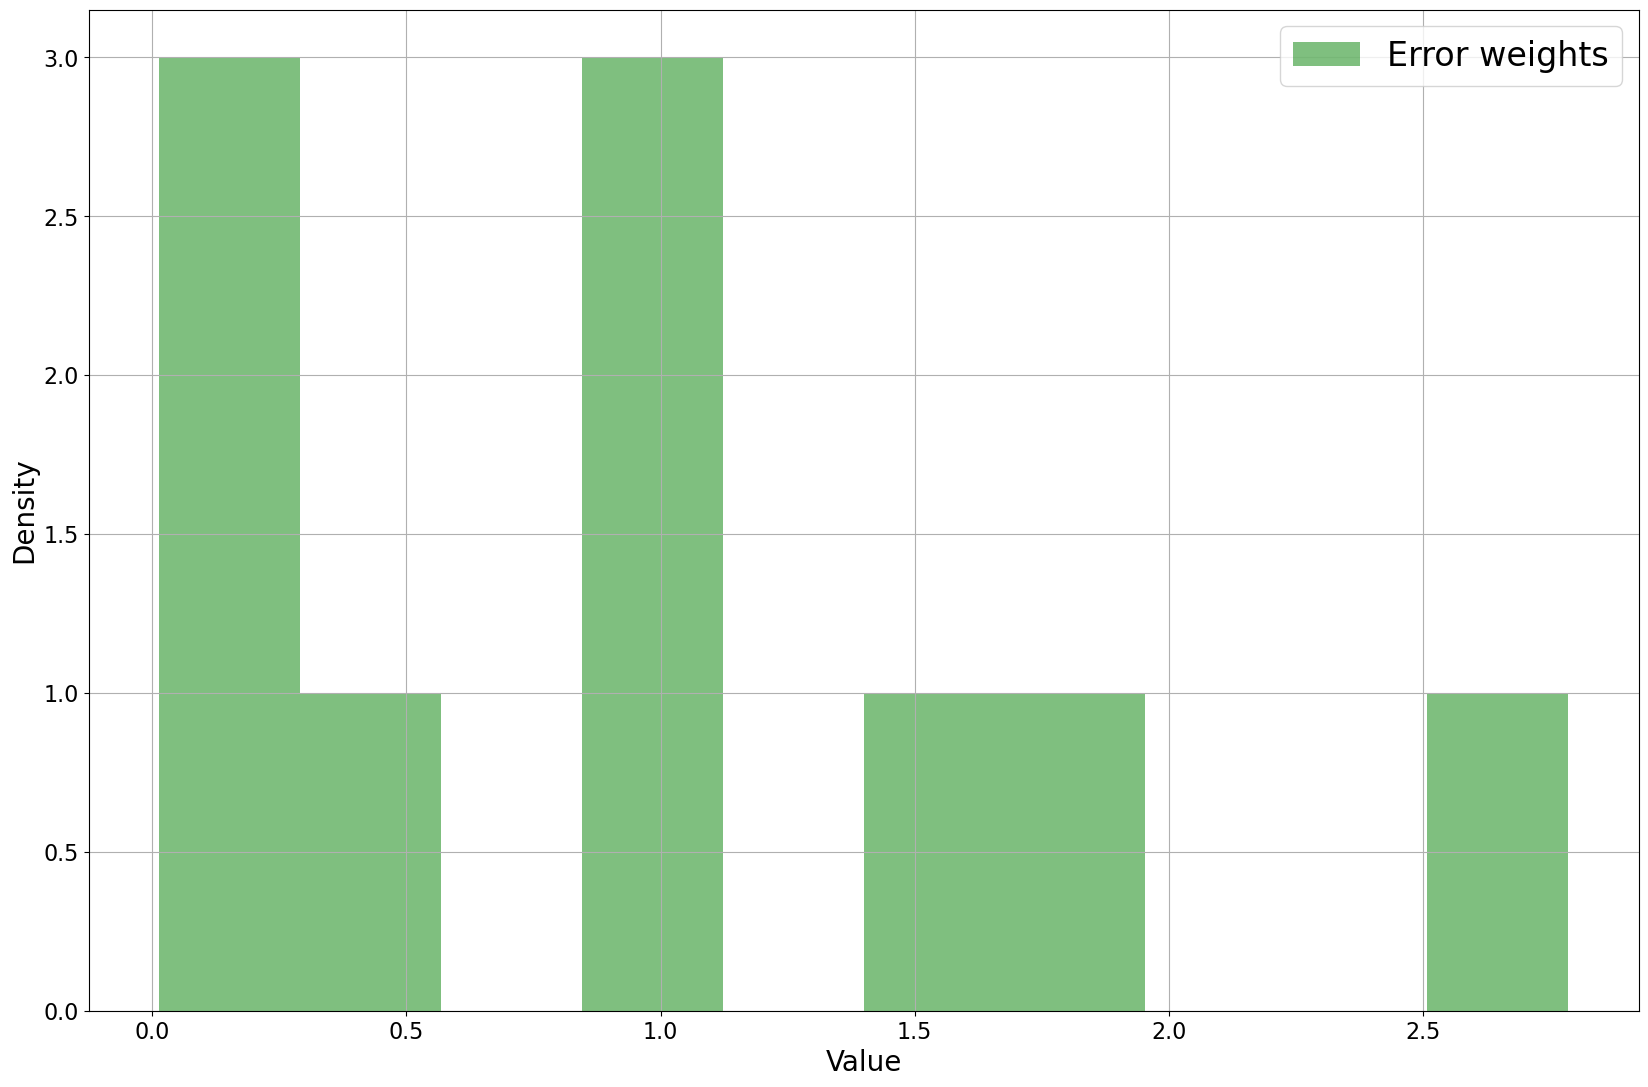

In [28]:
results_visualization.plot_lambdas_empirical_distribution("Train")

### 8.2 - Test

The Gaussian process posterior assumes that our centered function $f(\boldsymbol{X}_{test}) \sim \mathcal{N}(m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}), k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}))$. It implies that $\boldsymbol{Z}_{test} = k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test})^{-\frac{1}{2}} \left( f(\boldsymbol{X}_{test}) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}) \right) \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$. We are going to look at how relevant this hypothesis is.

##### 8.2.1 - Whitened test set

We first look at each component $z_n$ of the vector $\boldsymbol{Z}_{test}$. If the posterior Gaussian assumption holds, $\forall n \in [1, N_{test}], z_n \sim \mathcal{N}(0, 1)$. We plot the empirical distribution of $z_1,...,z_{N_{test}}$.

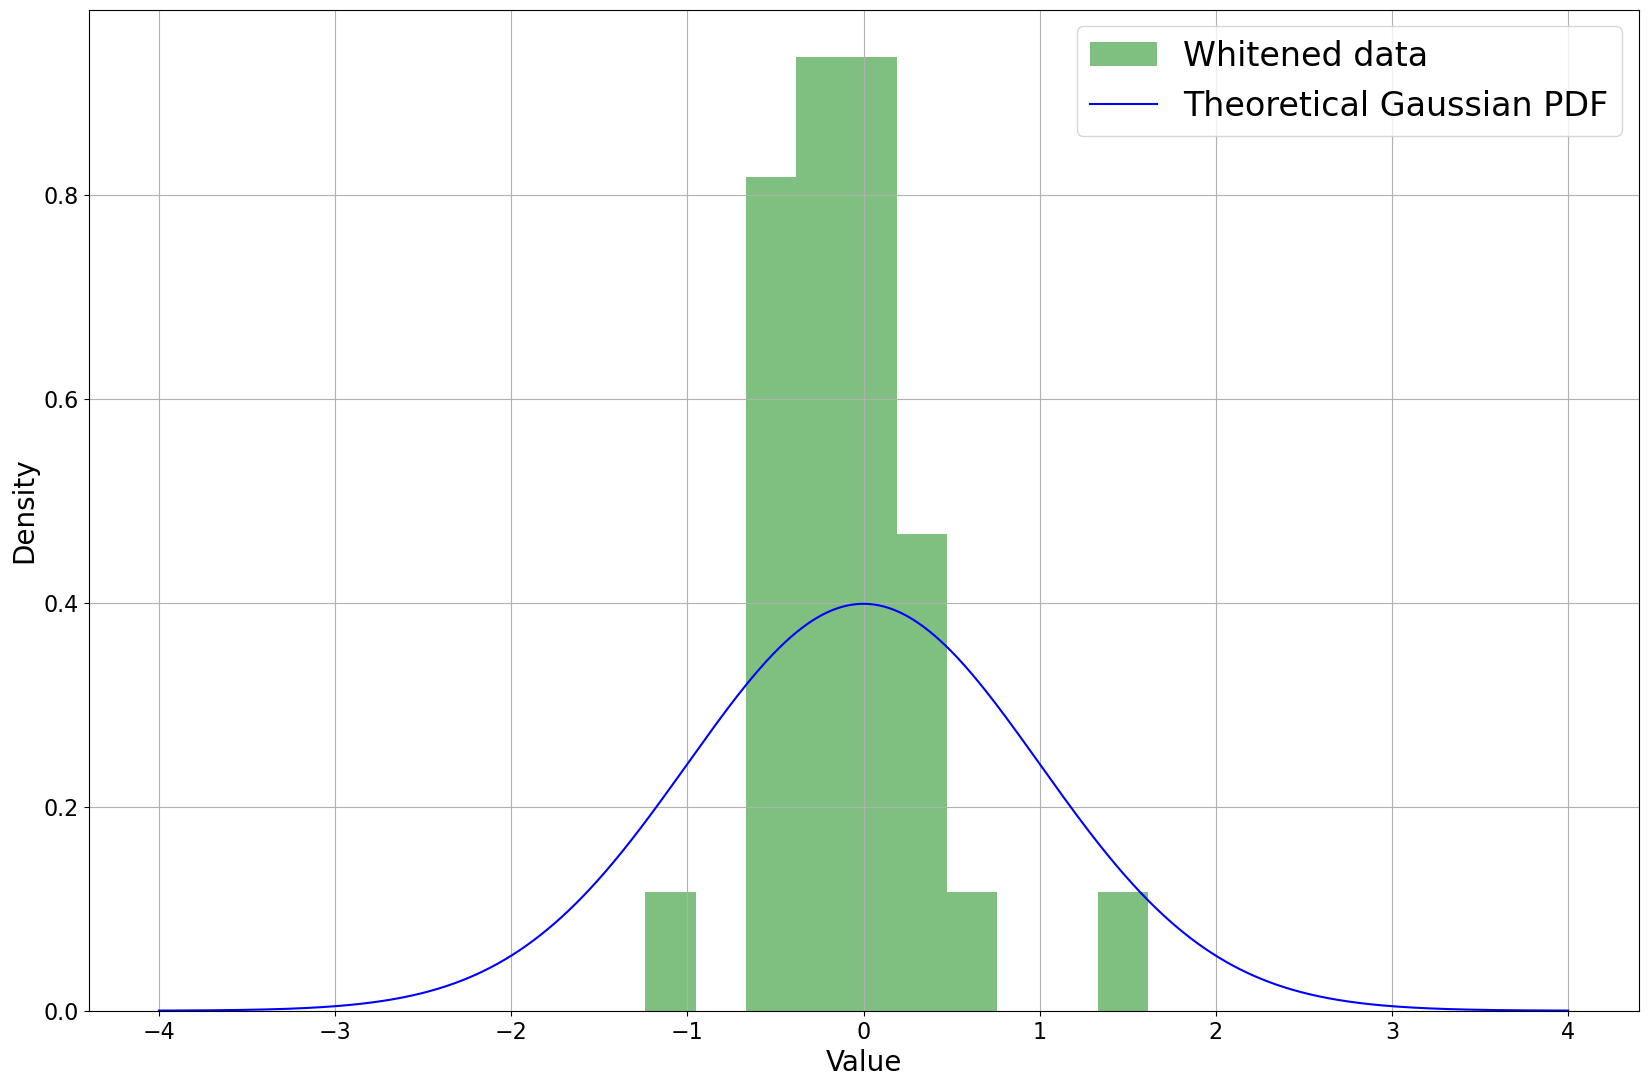

In [29]:
results_visualization.plot_whitened_data_assuming_gaussianity("Test")

##### 8.2.2 - Mahalanobis distance

We now look at the Mahalanobis distance of the vector $\boldsymbol{Z}_{test}$. If posterior Gaussian assumption holds, we have $\boldsymbol{Z}_{test}^T \boldsymbol{Z}_{test} \sim \chi^2(N_{test})$.

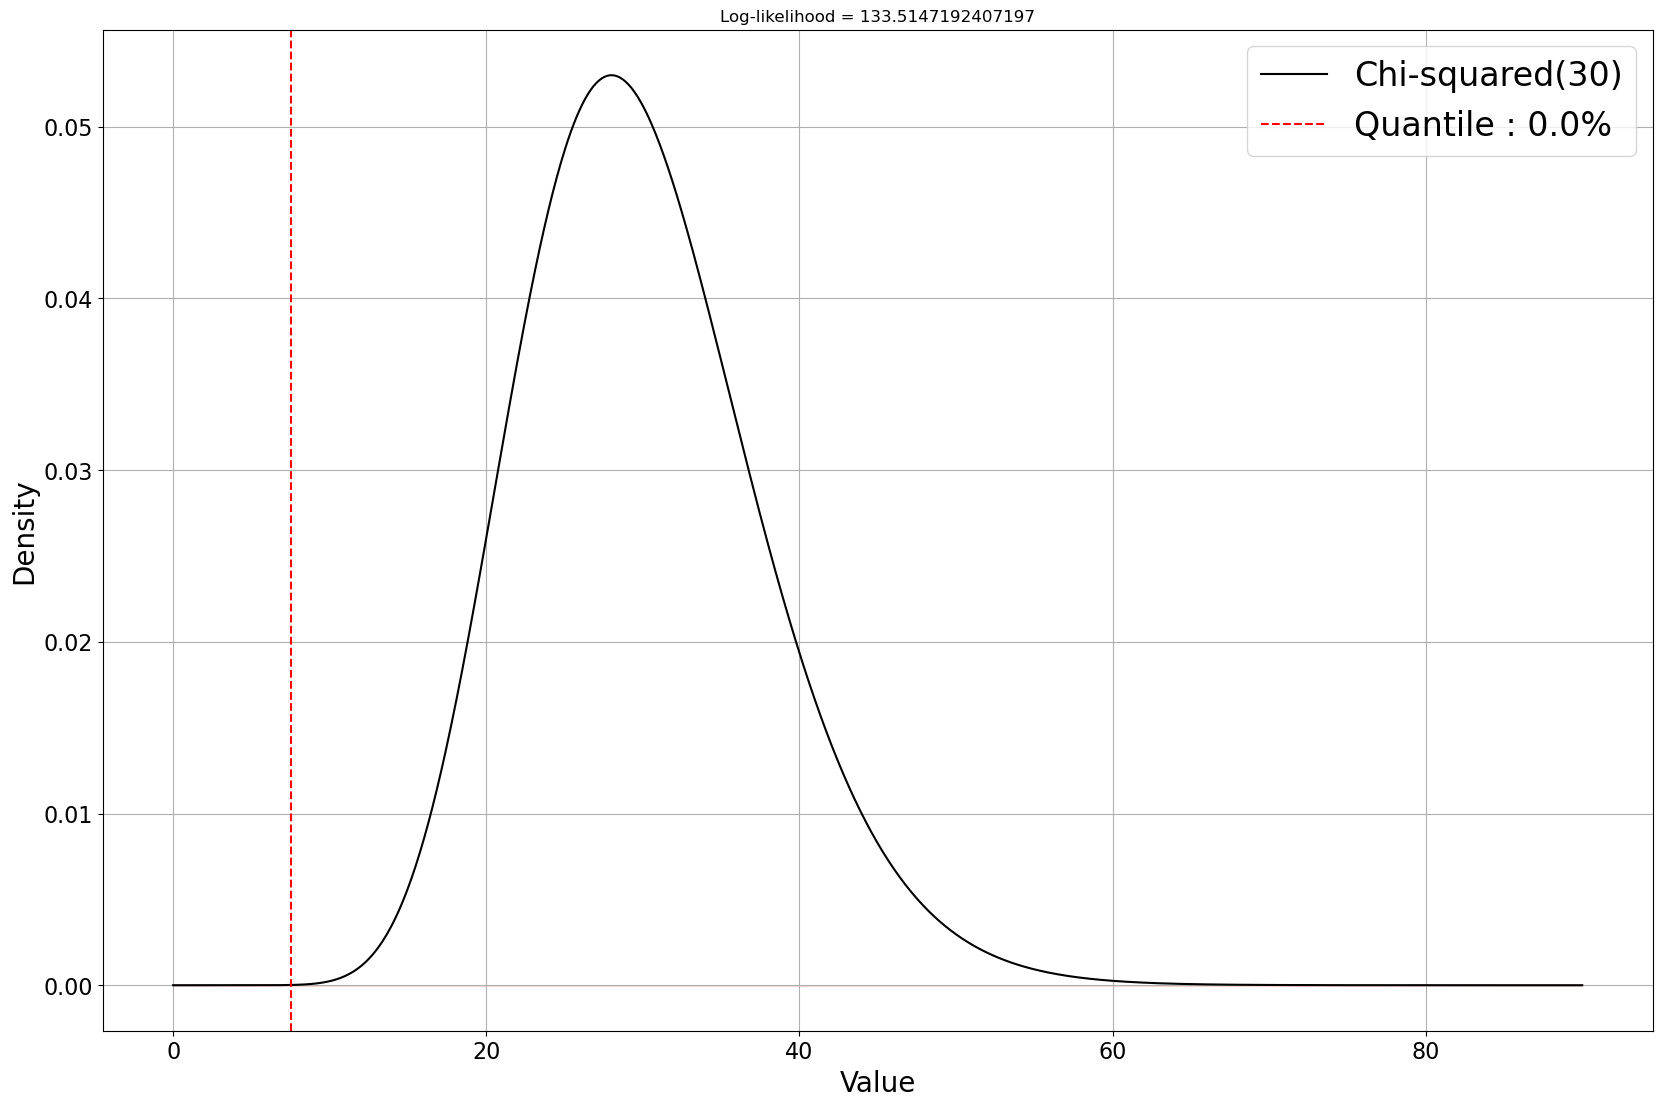

In [30]:
results_visualization.plot_mahalanobis_distance_distribution_assuming_gaussianity("Test")

##### 8.2.3 - Equivalent normal observation

We plot the observation of a 1-D normal distribution $\mathcal{N}(0, 1)$ that would have the same Mahalanobis distance.

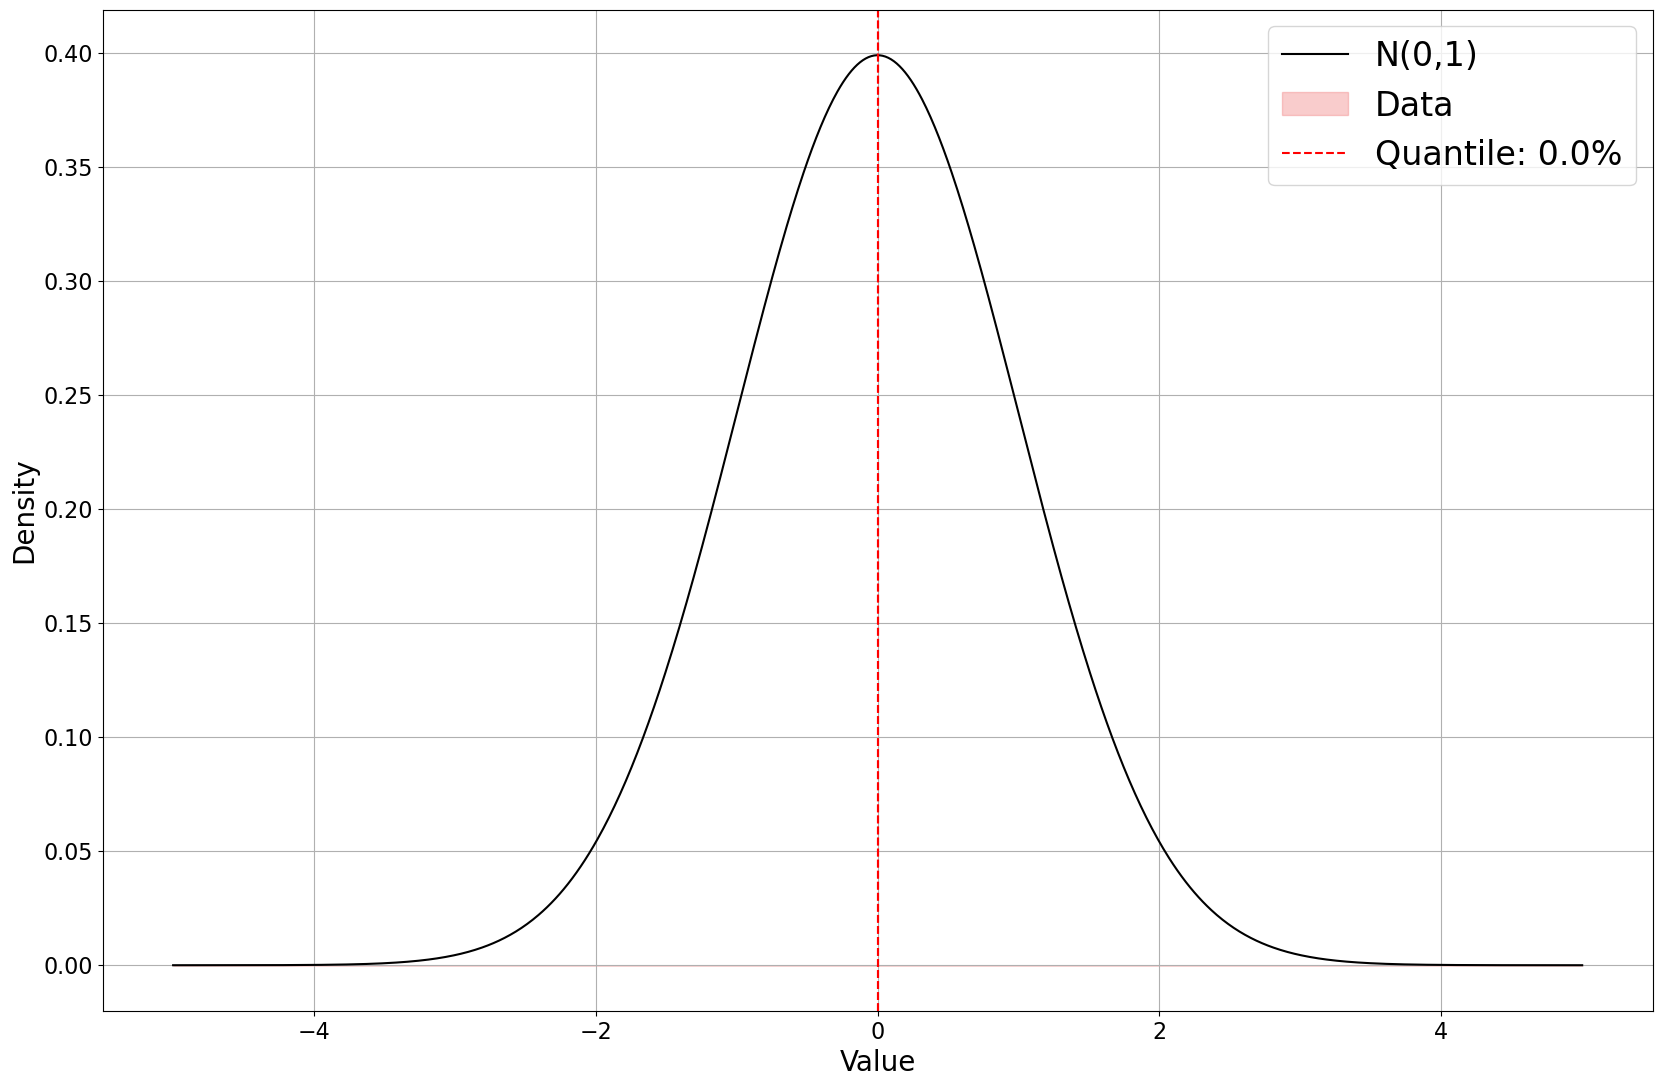

In [31]:
results_visualization.plot_equivalent_normal_observation_assuming_gaussianity("Test")

##### 8.2.4 - ECP

As for reliability, we compute the ECP. The only difference is we now compute the confidence interval in the probability space of the Gaussian process, taking into account the correlations between the predictions. Since there is no closed-form expression of this CI, we only provide a lower bound, assuming independent predictions. 

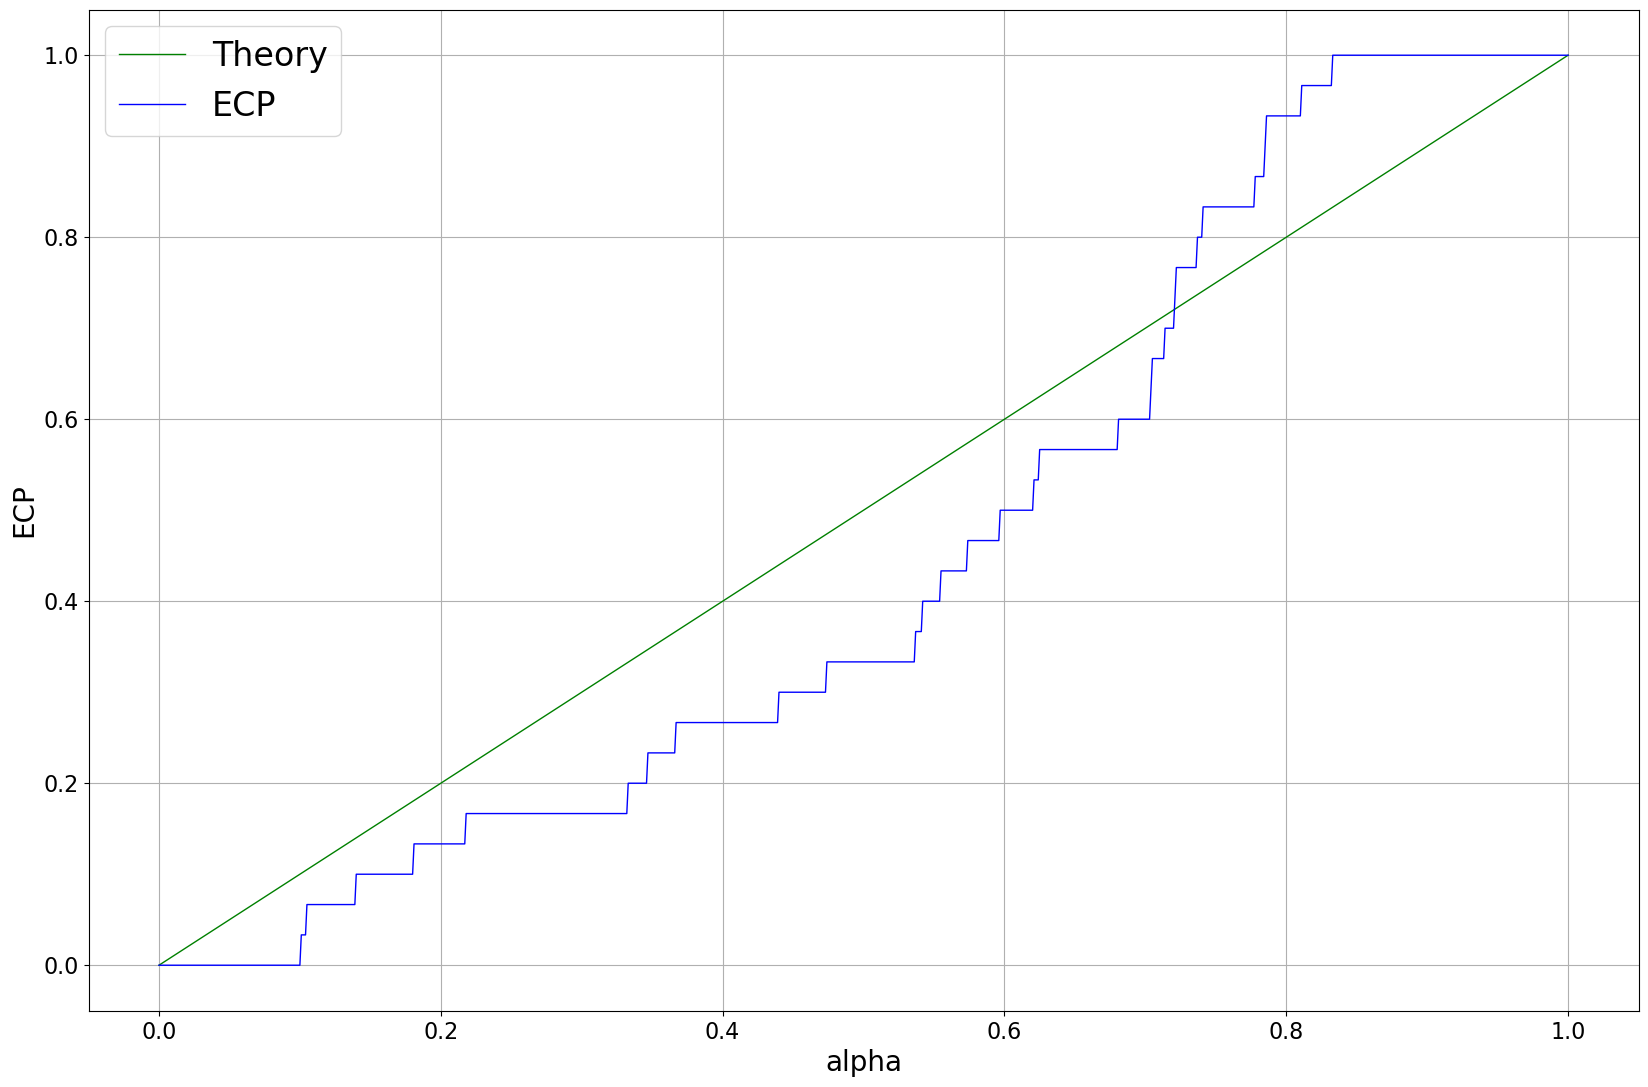

In [32]:
results_visualization.plot_empirical_coverage_probability_assuming_gaussianity("Test")

##### 8.2.5 - PVA

We compute the Predictive Variance Adequacy (PVA) $PVA = \frac{1}{N} \sum_{n=1}^N \frac{(f(\boldsymbol{x}_n) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n))^2}{k^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{x}_n, \boldsymbol{x}_n))}$. If the posterior Gaussian assumption holds, we should have $PVA \sim \sum_{n=1}^{N_{test}} \frac{\lambda_n}{N_{test}} \chi^2(1)$ with $\lambda_1,...,\lambda_{N_{test}}$ the eigenvalues of $Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test})\right)^{-\frac{1}{2}} k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) \right)^{-\frac{1}{2}} = \boldsymbol{P}_{test} \boldsymbol{D}_{test} \boldsymbol{P}_{test}^T$. $\boldsymbol{P}_{test}$ is chosen to be an orthogonal matrix.

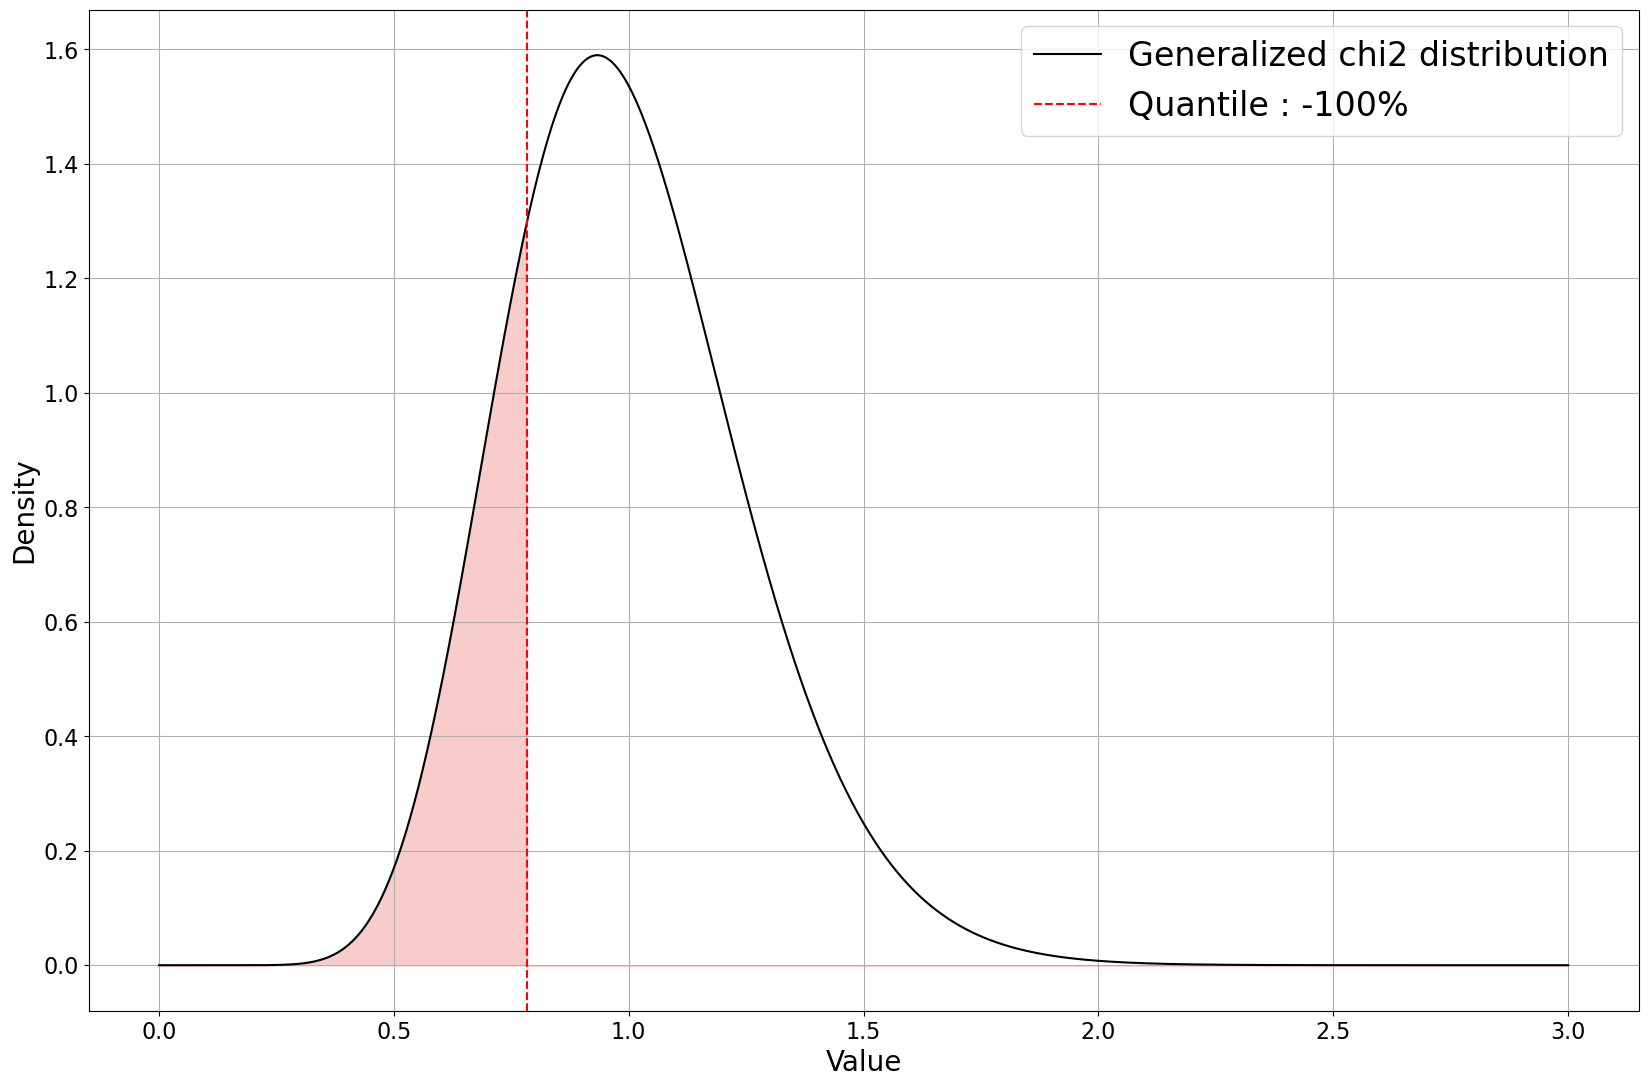

In [33]:
results_visualization.plot_predictive_variance_adequacy_assuming_gaussianity("Test")

##### 8.2.6 - Normalized prediction errors uncorrelated

One can notice that $PVA = ||Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) \right)^{-\frac{1}{2}} \left( f(\boldsymbol{X}_{test}) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}) \right)||^2 = ||\boldsymbol{P}_{test}^T Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) \right)^{-\frac{1}{2}} \left( f(\boldsymbol{X}_{test}) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}) \right)||^2$. We define:
- $\boldsymbol{Y}_{test} = Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) \right)^{-\frac{1}{2}} \left( f(\boldsymbol{X}_{test}) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}) \right)$.
- $\boldsymbol{W}_{test} = \boldsymbol{D}_{test}^{-\frac{1}{2}} \boldsymbol{P}_{test}^T Diag\left( k_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}, \boldsymbol{X}_{test}) \right)^{-\frac{1}{2}} \left( f(\boldsymbol{X}_{test}) - m^{posterior}_{\boldsymbol{\theta}}(\boldsymbol{X}_{test}) \right)$.

Then:
- $PVA = \sum_{n=1}^{N_{test}} \boldsymbol{Y}_{test}^{(n)2}$ and under the prior Gaussian assumption, $\forall n \in [1, N_{test}], \boldsymbol{Y}_{train}^{(n)2} \sim \chi^2(1)$
- $PVA = \sum_{n=1}^{N_{test}} \lambda_n \boldsymbol{W}_{test}^{(n)2}$ and under the prior Gaussian assumption, $\forall n \in [1, N_{test}], \boldsymbol{W}_{test}^{(n)2} \sim \chi^2(1)$

We decorrelated the errors. The usual correlated ECP computed on the test set can then be written as $ECP(1 - \alpha) = \frac{1}{N_{test}} \sum_{n=1}^{N_{test}} \mathbb{1}_{\{ |\boldsymbol{Y}_{test}^{(n)}| \leq q_{1 - \frac{\alpha}{2}}\}}$. One could then naturally extend to a new uncorrelated ECP computed on the test set by $NECP(1 - \alpha) = \frac{1}{N_{test}} \sum_{n=1}^{N_{test}} \lambda_n \mathbb{1}_{\{ |\boldsymbol{W}_{test}^{(n)}| \leq q_{1 - \frac{\alpha}{2}}\}}$. The difference is that now, if the posterior Gaussian assumption holds, $\boldsymbol{W}_{test} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{D}_{test})$. The components are independent, so we call this new ECP uncorrelated ECP. Unlike correlated ECP, we can compute exact confidence intervals around the ECP in the probability space of the Gaussian process.

We now plot the empirical distribution of each uncorrelated normalized error $\boldsymbol{W}_{test}^{(n)}$ and also show the associated $\lambda_n$. A high value of $\lambda_n$ indicates that many predictions on the test set share this error.

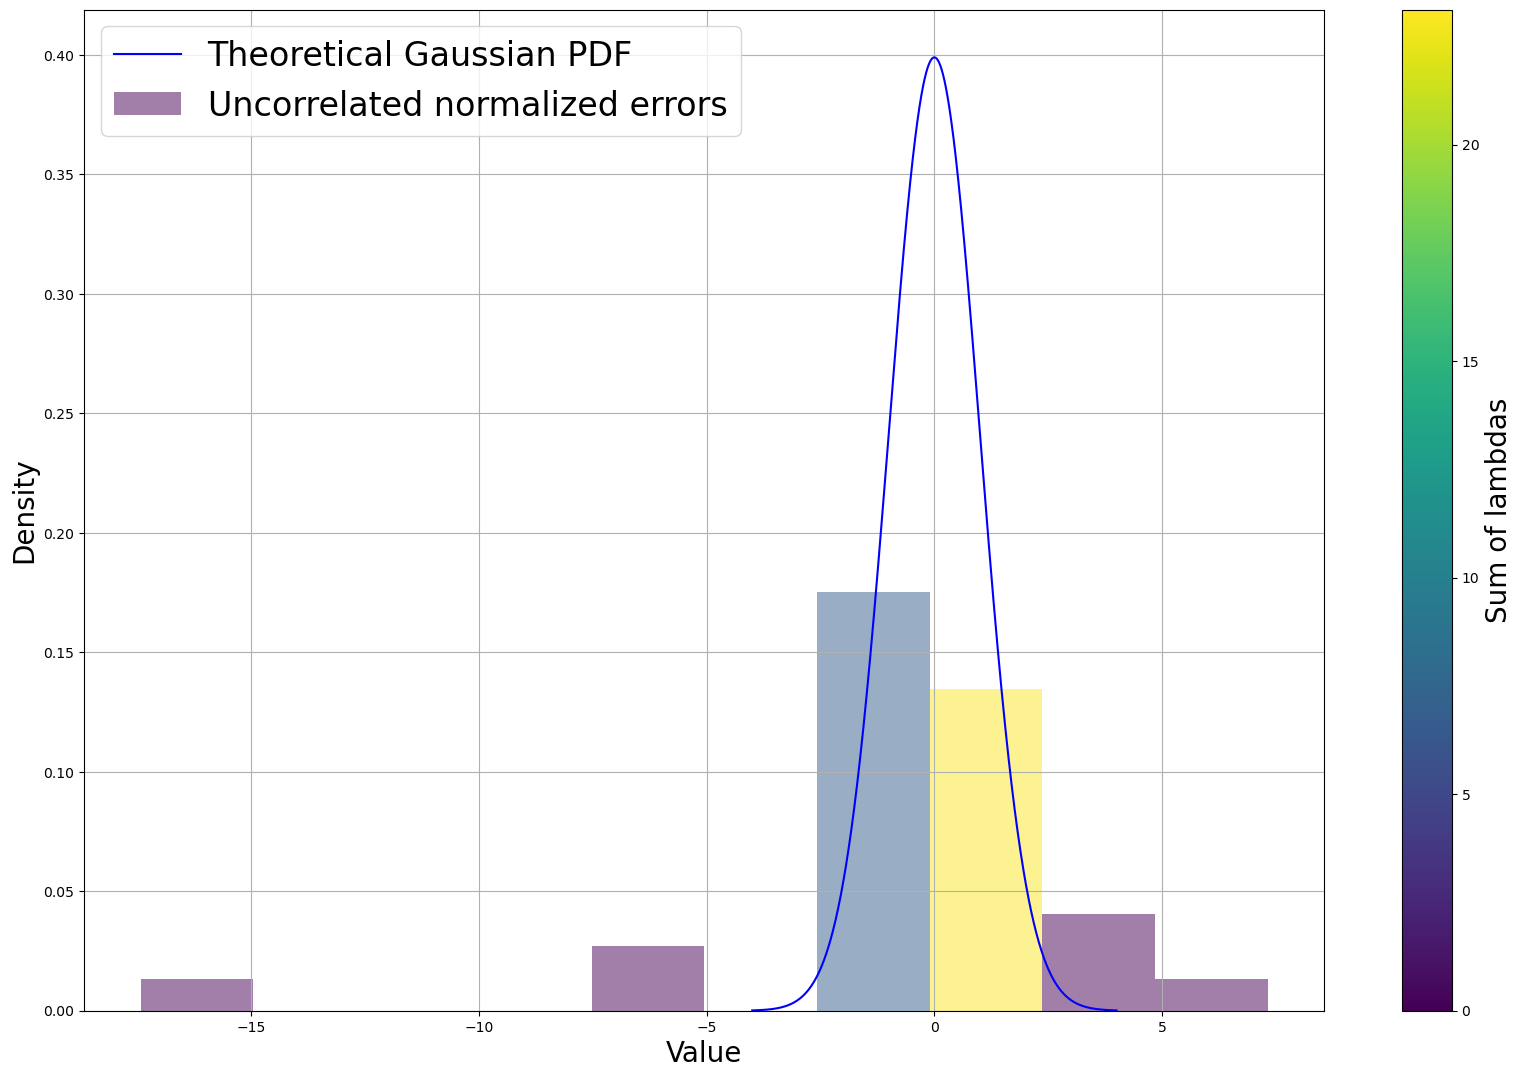

In [34]:
results_visualization.plot_normalized_prediction_errors_uncorrelated_assuming_gaussianity("Test")

##### 8.2.7 - $\lambda_n$ empirical distribution

Finally, we plot the empirical distribution of the eigenvalues $\lambda_n$ to see to what extent the errors are correlated.

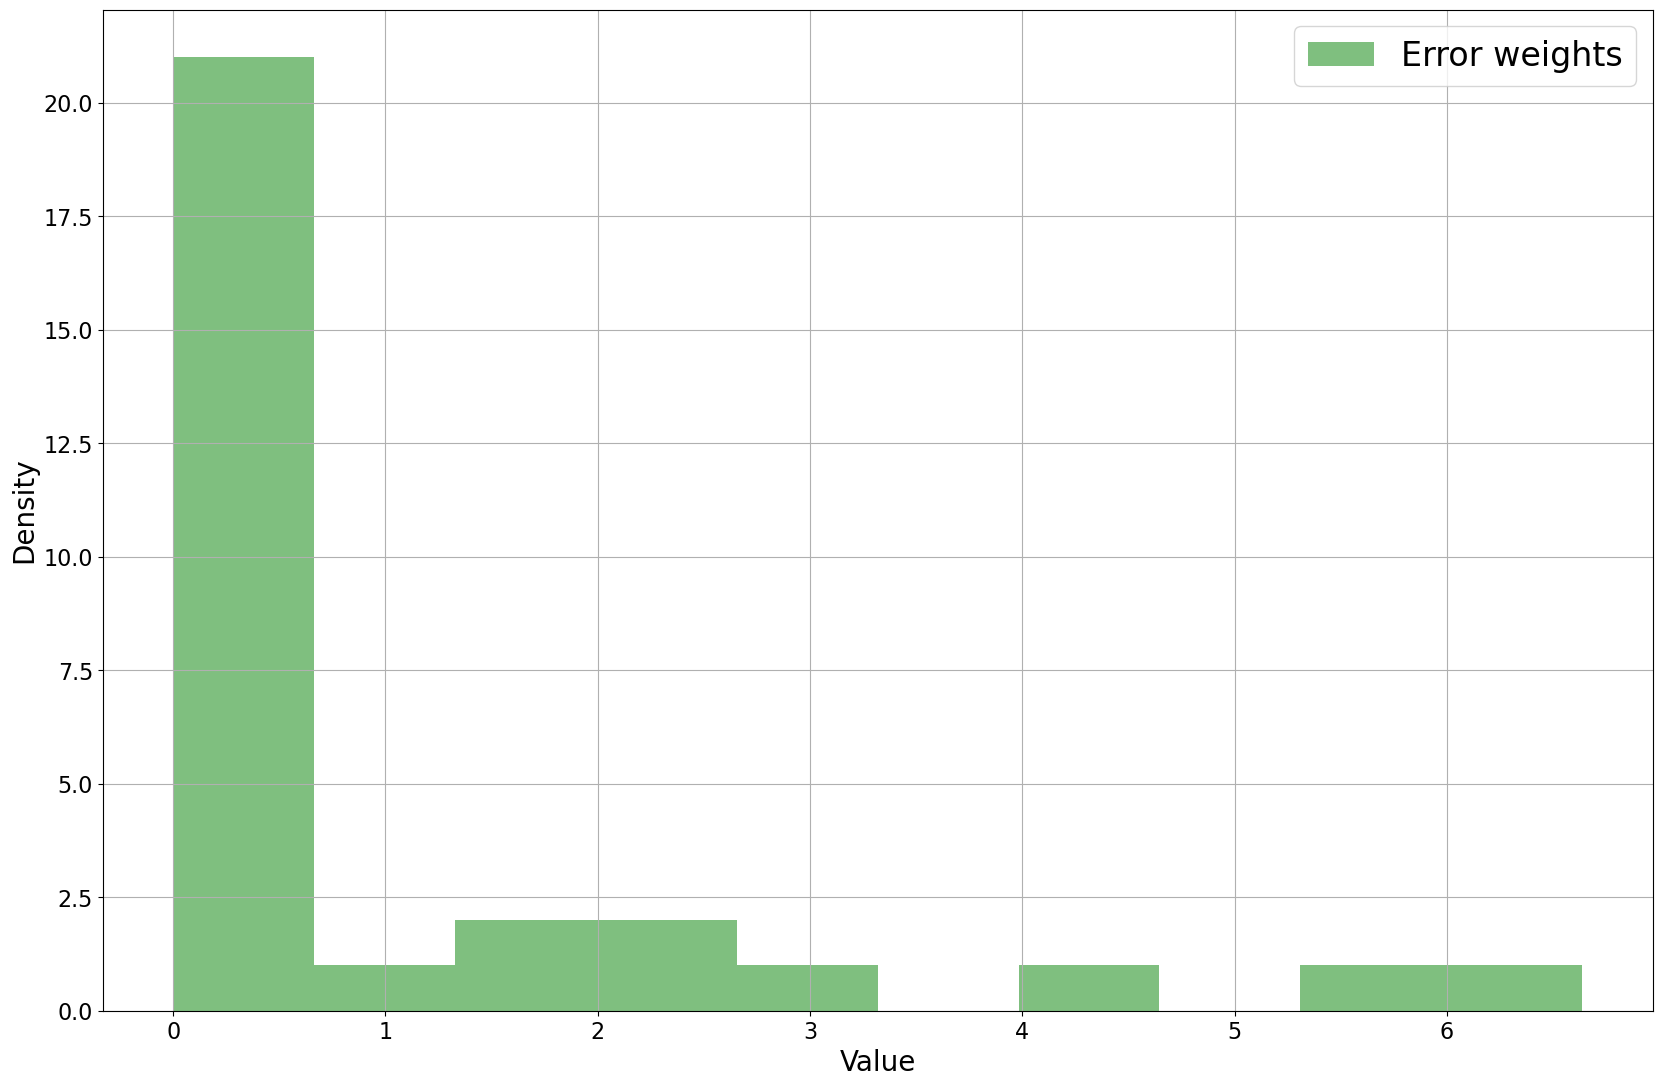

In [35]:
results_visualization.plot_lambdas_empirical_distribution("Test")

# 9 - Metrics

### 9.1 - Reliability

##### 9.1.1 - Train

In [36]:
results_visualization.show_reliability_metrics("Train")

PVA       : 0.7442529417216217 - n = 10
95% ECP : 1.0
IAE       : 53.121999999999986
PMIW      : 0.2557206784034306


##### 9.1.2 - Test

In [37]:
results_visualization.show_reliability_metrics("Test")

PVA       : 0.7824617238125685 - n = 30
95% ECP : 1.0
IAE       : 98.45333333333335
PMIW      : 41.79219764952584


### 9.2 - Performance

##### 9.2.1 - Train

In [38]:
results_visualization.show_performance_metrics("Train")

MSE : 0.049061553550535875
Q2  : 0.7136045065658754


##### 9.2.2 - Test

In [39]:
results_visualization.show_performance_metrics("Test")

MSE : 0.06409212513316619
Q2  : 0.6495395472776109


### 9.3 - Hybrid

##### 9.3.1 - Train

In [40]:
results_visualization.show_hybrid_metrics("Train")

NLPD     : -1.162947851324798
CRPS     : 0.12350086919853506
95% IS : 4.195642408618232


##### 9.3.2 - Test

In [41]:
results_visualization.show_hybrid_metrics("Test")

NLPD     : -1.5606317165971155
CRPS     : 0.12136837078609988
95% IS : 6.46340746953317
